# Exercice 1 : Self-Attention mechanism: basic implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#  Fonction d’affichage
def plot_matrix(matrix, title):
    plt.figure(figsize=(6, 5))
    plt.imshow(matrix, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title(title)
    plt.show()

# 1. Nouvelle séquence d’entrée avec dimension de batch 
input_sequence = np.array([[[1, 0, 1, 0],
                            [0, 2, 1, 0],
                            [1, 1, 0, 1]]], dtype=float)  # shape = (1, 3, 4)


In [2]:
def self_attention(input_seq, num_heads=1, scaling_factor=None):
    batch_size, seq_len, d_model = input_seq.shape
    depth = d_model // num_heads  # dimension par tête
    
    # Projections linéaires Q, K, V
    Wq = tf.keras.layers.Dense(d_model)
    Wk = tf.keras.layers.Dense(d_model)
    Wv = tf.keras.layers.Dense(d_model)
    
    Q = Wq(input_seq)
    K = Wk(input_seq)
    V = Wv(input_seq)
    
    # Si multi-head 
    if num_heads > 1:
        # Découper chaque matrice en 'num_heads'
        def split_heads(x):
            x = tf.reshape(x, (batch_size, seq_len, num_heads, depth))
            return tf.transpose(x, perm=[0, 2, 1, 3])  # (batch, heads, seq_len, depth)
        Q = split_heads(Q)
        K = split_heads(K)
        V = split_heads(V)
        
        # Calcul des scores : Q × K^T
        scores = tf.matmul(Q, K, transpose_b=True)
        
        # Scaling 
        if scaling_factor is None:
            scaling_factor = tf.sqrt(tf.cast(depth, tf.float32))
        scores /= scaling_factor
        
        # Softmax sur les scores
        weights = tf.nn.softmax(scores, axis=-1)
        
        # Sortie
        output = tf.matmul(weights, V)
        
        # Reconcaténer les têtes
        output = tf.transpose(output, perm=[0, 2, 1, 3])  # (batch, seq_len, heads, depth)
        output = tf.reshape(output, (batch_size, seq_len, d_model))
    
    else:  # Single head 
        scores = tf.matmul(Q, K, transpose_b=True)
        if scaling_factor is None:
            scaling_factor = tf.sqrt(tf.cast(d_model, tf.float32))
        scores /= scaling_factor
        weights = tf.nn.softmax(scores, axis=-1)
        output = tf.matmul(weights, V)
    
    return Q, K, V, scores, weights, output


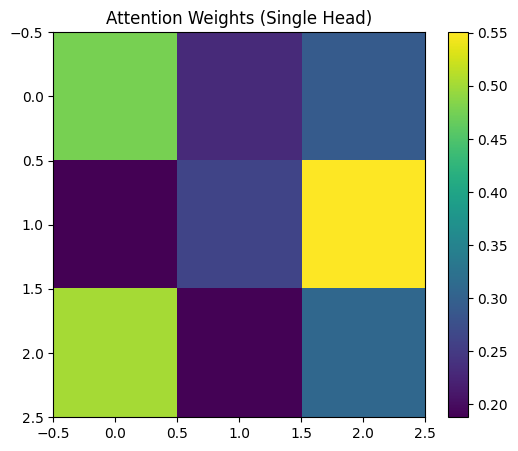

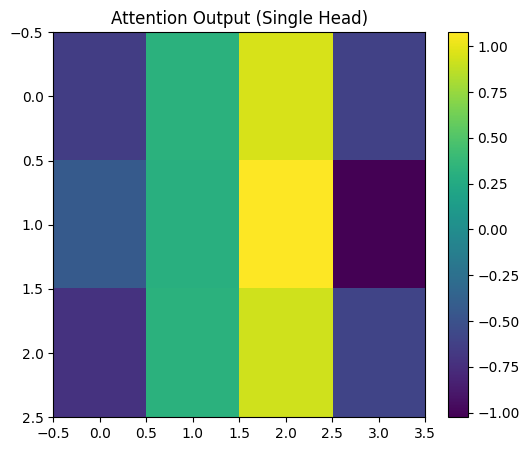

In [3]:
# Cas 1 : Single head 
Q1, K1, V1, scores1, weights1, output1 = self_attention(input_sequence, num_heads=1)

plot_matrix(tf.squeeze(weights1), "Attention Weights (Single Head)")
plot_matrix(tf.squeeze(output1), "Attention Output (Single Head)")


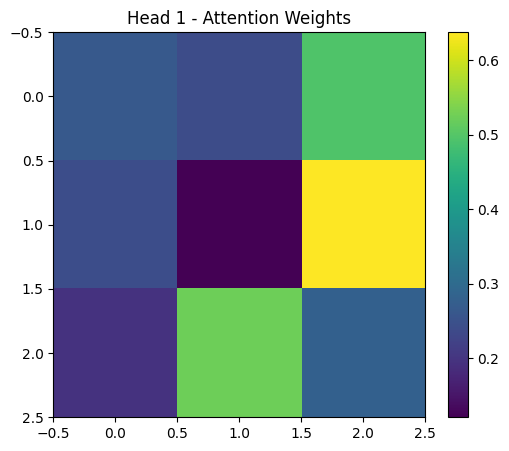

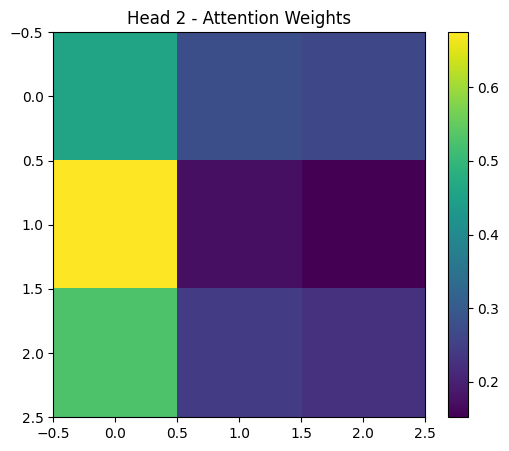

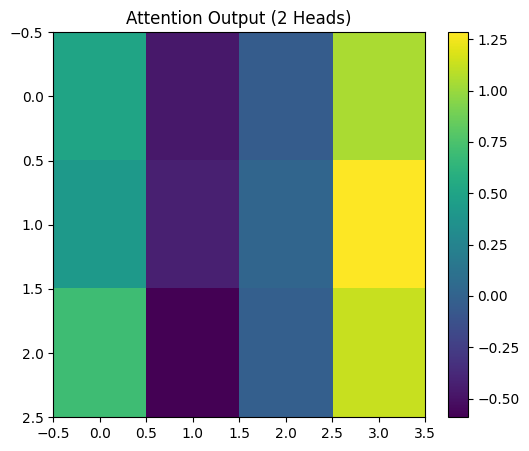

In [4]:
#  Cas 2 : Multi-head (2 heads)
Q2, K2, V2, scores2, weights2, output2 = self_attention(input_sequence, num_heads=2)

# Visualiser les poids d’attention de la première tête
plot_matrix(tf.squeeze(weights2[0,0]), "Head 1 - Attention Weights")
plot_matrix(tf.squeeze(weights2[0,1]), "Head 2 - Attention Weights")
plot_matrix(tf.squeeze(output2), "Attention Output (2 Heads)")


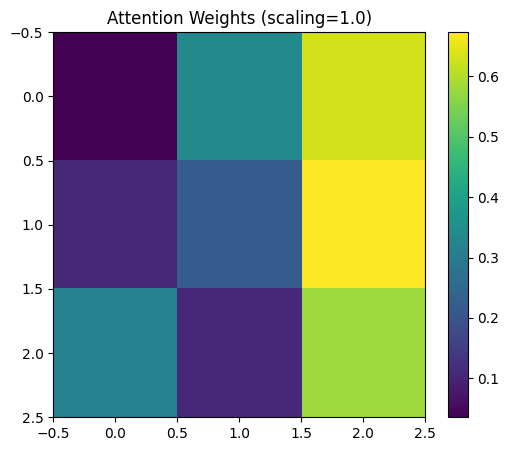

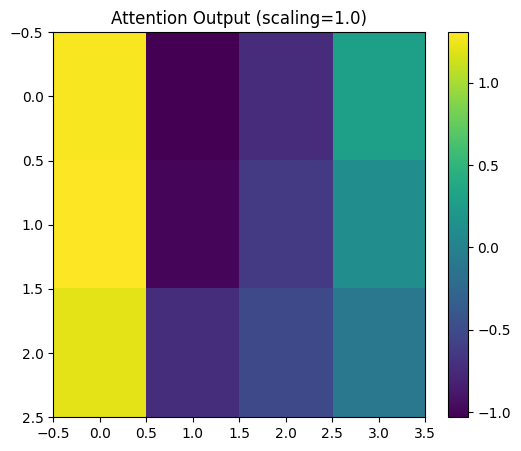

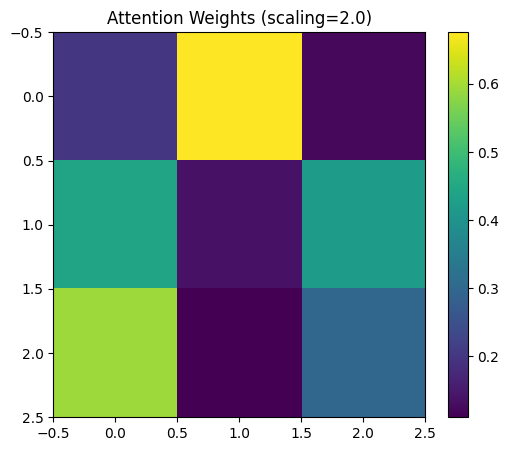

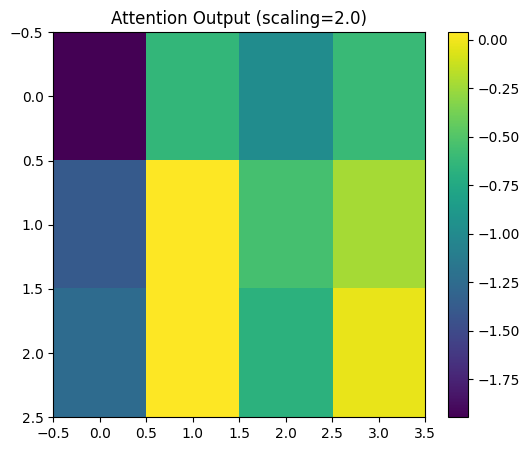

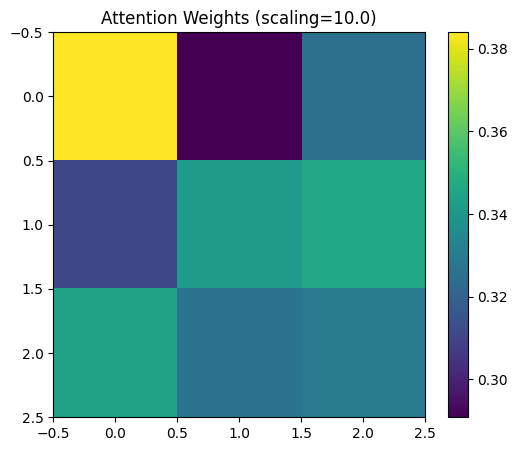

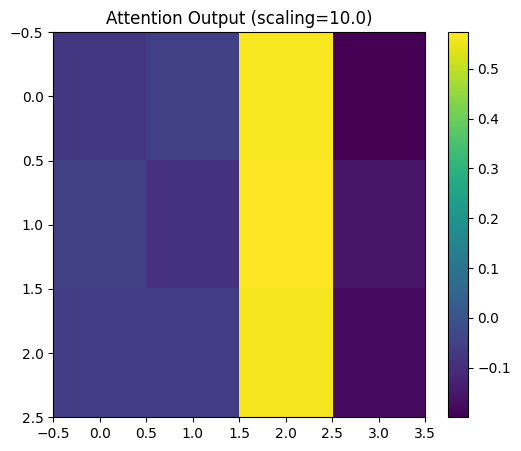

In [5]:
for scale in [1.0, 2.0, 10.0]:
    _, _, _, scores, weights, output = self_attention(input_sequence, num_heads=1, scaling_factor=scale)
    plot_matrix(tf.squeeze(weights), f"Attention Weights (scaling={scale})")
    plot_matrix(tf.squeeze(output), f"Attention Output (scaling={scale})")


# Exercice 2: Self-Attention mechanism: Using a sentence as input

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)


sentence = ["I", "really", "love", "playing", "tennis"]
embedding_dim = 4

np.random.seed(42)
embeddings = {word: np.random.rand(embedding_dim) for word in sentence}

inputs = np.array([embeddings[word] for word in sentence])


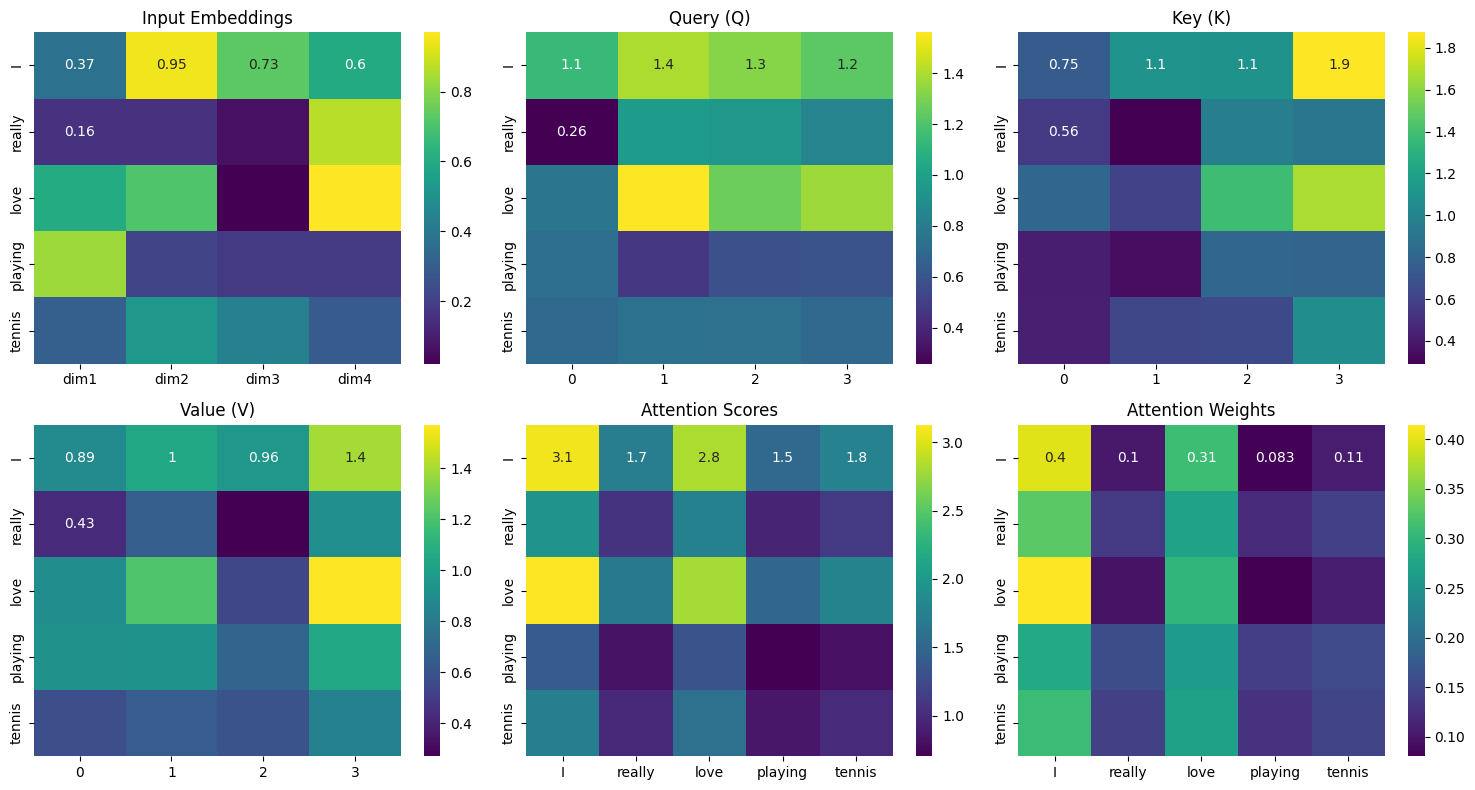

In [7]:
# Initialisation des poids pour Q, K, V 
Wq = np.random.rand(embedding_dim, embedding_dim)
Wk = np.random.rand(embedding_dim, embedding_dim)
Wv = np.random.rand(embedding_dim, embedding_dim)


Q = np.dot(inputs, Wq)
K = np.dot(inputs, Wk)
V = np.dot(inputs, Wv)


scores = np.dot(Q, K.T) / np.sqrt(K.shape[1])
attention_weights = softmax(scores)
output = np.dot(attention_weights, V)


plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
sns.heatmap(inputs, annot=True, cmap='viridis', xticklabels=[f"dim{i}" for i in range(1, embedding_dim+1)], yticklabels=sentence)
plt.title('Input Embeddings')

plt.subplot(2, 3, 2)
sns.heatmap(Q, annot=True, cmap='viridis', yticklabels=sentence)
plt.title('Query (Q)')

plt.subplot(2, 3, 3)
sns.heatmap(K, annot=True, cmap='viridis', yticklabels=sentence)
plt.title('Key (K)')

plt.subplot(2, 3, 4)
sns.heatmap(V, annot=True, cmap='viridis', yticklabels=sentence)
plt.title('Value (V)')

plt.subplot(2, 3, 5)
sns.heatmap(scores, annot=True, cmap='viridis', xticklabels=sentence, yticklabels=sentence)
plt.title('Attention Scores')

plt.subplot(2, 3, 6)
sns.heatmap(attention_weights, annot=True, cmap='viridis', xticklabels=sentence, yticklabels=sentence)
plt.title('Attention Weights')

plt.tight_layout()
plt.show()


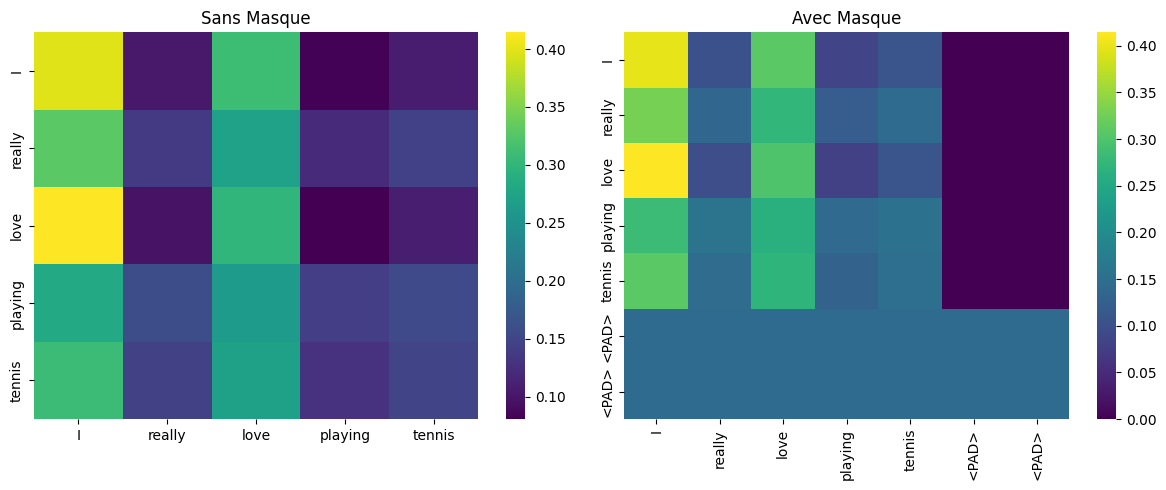

In [8]:
sentence_masked = ["I", "really", "love", "playing", "tennis", "<PAD>", "<PAD>"]


embeddings_masked = embeddings.copy()
embeddings_masked["<PAD>"] = np.zeros(embedding_dim)
inputs_masked = np.array([embeddings_masked[word] for word in sentence_masked])


Qm = np.dot(inputs_masked, Wq)
Km = np.dot(inputs_masked, Wk)
Vm = np.dot(inputs_masked, Wv)
scores_m = np.dot(Qm, Km.T) / np.sqrt(Km.shape[1])


mask = np.array([1, 1, 1, 1, 1, 0, 0])
mask_matrix = np.outer(mask, mask)


masked_scores = np.where(mask_matrix == 1, scores_m, -1e9)


attention_weights_masked = softmax(masked_scores)
output_masked = np.dot(attention_weights_masked, Vm)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(attention_weights, annot=False, cmap='viridis', xticklabels=sentence, yticklabels=sentence)
plt.title("Sans Masque")

plt.subplot(1, 2, 2)
sns.heatmap(attention_weights_masked, annot=False, cmap='viridis', xticklabels=sentence_masked, yticklabels=sentence_masked)
plt.title("Avec Masque")
plt.tight_layout()
plt.show()


# Exercice 3: Self-Attention mechanism: Compute word embeddings


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec


sentence = "Data science is transforming the world of technology".split()


model = Word2Vec([sentence], vector_size=8, window=3, min_count=1, sg=1, seed=42)


embeddings = np.array([model.wv[word] for word in sentence])
embedding_dim = embeddings.shape[1]
vocab_size = len(sentence)

print("Embeddings shape:", embeddings.shape)


Embeddings shape: (8, 8)


In [10]:
def xavier_init(in_dim, out_dim):
    limit = np.sqrt(6 / (in_dim + out_dim))
    return np.random.uniform(-limit, limit, (in_dim, out_dim))

np.random.seed(0)
Wq = xavier_init(embedding_dim, embedding_dim)
Wk = xavier_init(embedding_dim, embedding_dim)
Wv = xavier_init(embedding_dim, embedding_dim)


Q = np.dot(embeddings, Wq)
K = np.dot(embeddings, Wk)
V = np.dot(embeddings, Wv)


In [11]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

scores = np.dot(Q, K.T) / np.sqrt(embedding_dim)
attention_weights = softmax(scores)
output = np.dot(attention_weights, V)


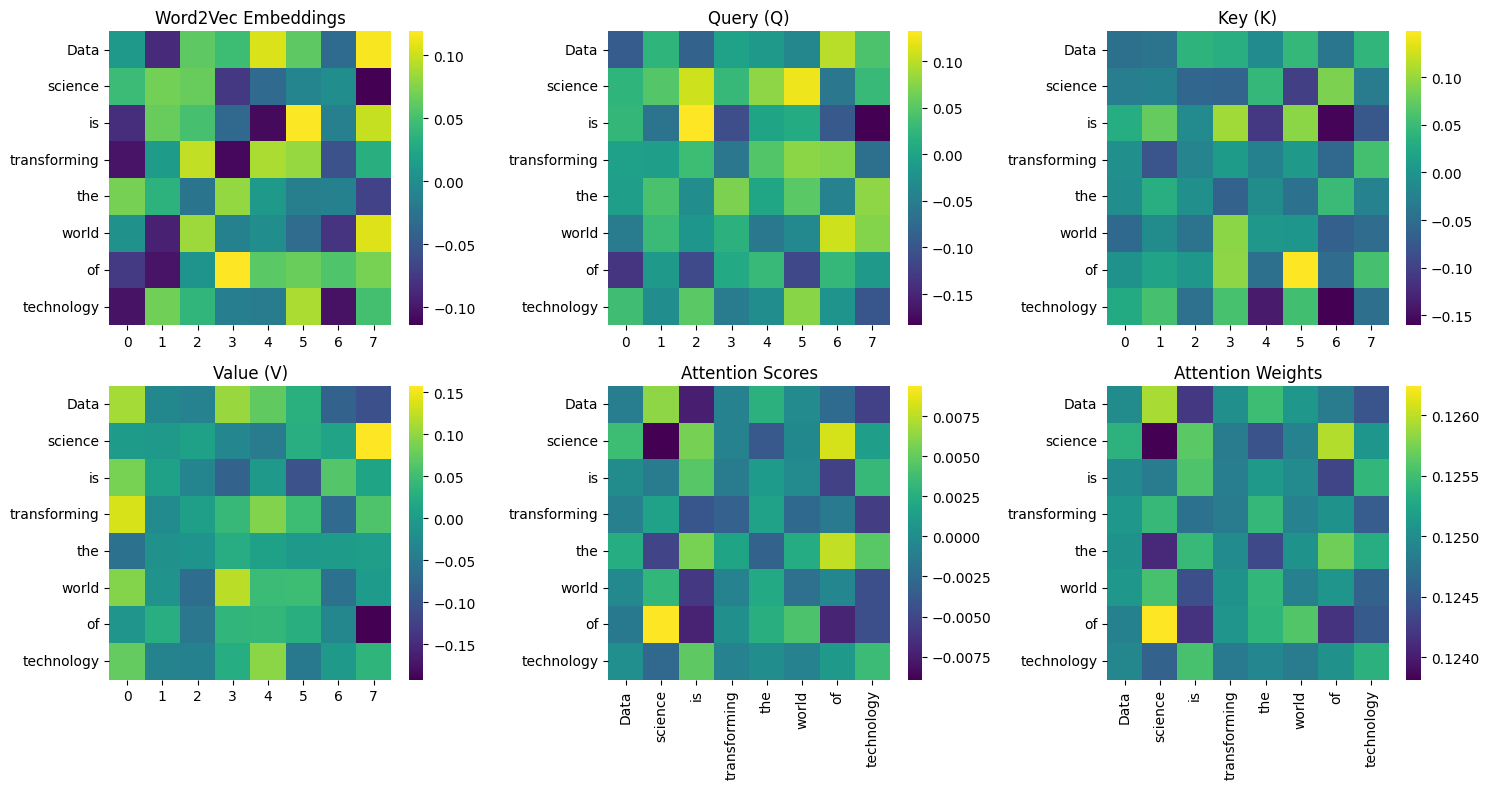

In [12]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
sns.heatmap(embeddings, cmap='viridis', yticklabels=sentence)
plt.title("Word2Vec Embeddings")

plt.subplot(2, 3, 2)
sns.heatmap(Q, cmap='viridis', yticklabels=sentence)
plt.title("Query (Q)")

plt.subplot(2, 3, 3)
sns.heatmap(K, cmap='viridis', yticklabels=sentence)
plt.title("Key (K)")

plt.subplot(2, 3, 4)
sns.heatmap(V, cmap='viridis', yticklabels=sentence)
plt.title("Value (V)")

plt.subplot(2, 3, 5)
sns.heatmap(scores, cmap='viridis', xticklabels=sentence, yticklabels=sentence)
plt.title("Attention Scores")

plt.subplot(2, 3, 6)
sns.heatmap(attention_weights, cmap='viridis', xticklabels=sentence, yticklabels=sentence)
plt.title("Attention Weights")

plt.tight_layout()
plt.show()


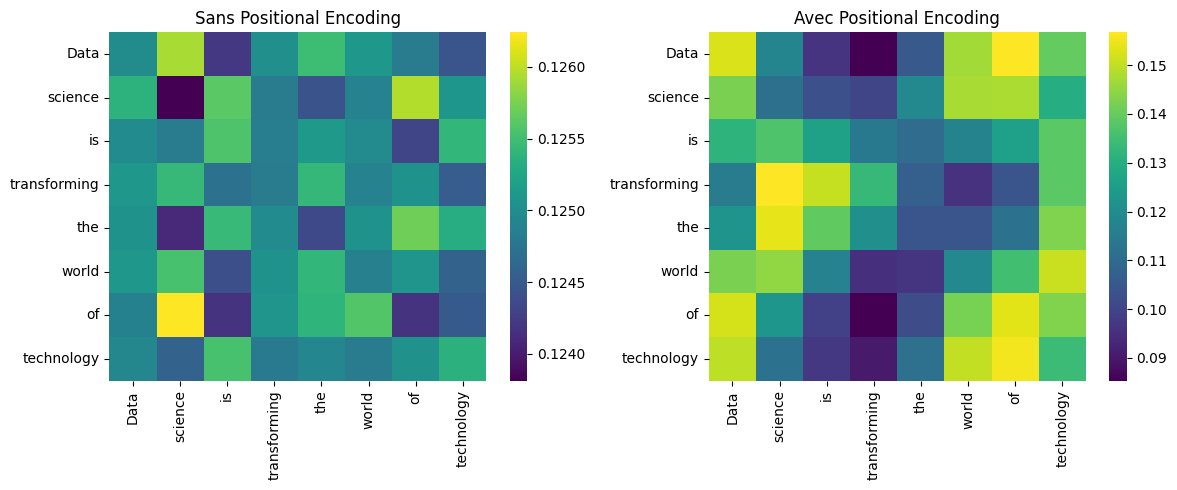

In [13]:
def positional_encoding(seq_len, d_model):
    PE = np.zeros((seq_len, d_model))
    for pos in range(seq_len):
        for i in range(0, d_model, 2):
            PE[pos, i] = np.sin(pos / (10000 ** ((2 * i)/d_model)))
            if i + 1 < d_model:
                PE[pos, i + 1] = np.cos(pos / (10000 ** ((2 * i)/d_model)))
    return PE

PE = positional_encoding(vocab_size, embedding_dim)
embeddings_pos = embeddings + PE  # ajout positionnel

Qp = np.dot(embeddings_pos, Wq)
Kp = np.dot(embeddings_pos, Wk)
Vp = np.dot(embeddings_pos, Wv)
scores_p = np.dot(Qp, Kp.T) / np.sqrt(embedding_dim)
att_weights_p = softmax(scores_p)
output_p = np.dot(att_weights_p, Vp)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(attention_weights, cmap='viridis', xticklabels=sentence, yticklabels=sentence)
plt.title("Sans Positional Encoding")

plt.subplot(1, 2, 2)
sns.heatmap(att_weights_p, cmap='viridis', xticklabels=sentence, yticklabels=sentence)
plt.title("Avec Positional Encoding")
plt.tight_layout()
plt.show()


# Exercice 4: Self-Attention mechanism: Varying Parameters



=== EMBEDDING DIMENSION = 4 ===

--- d=4 | heads=1 | dropout=0.0


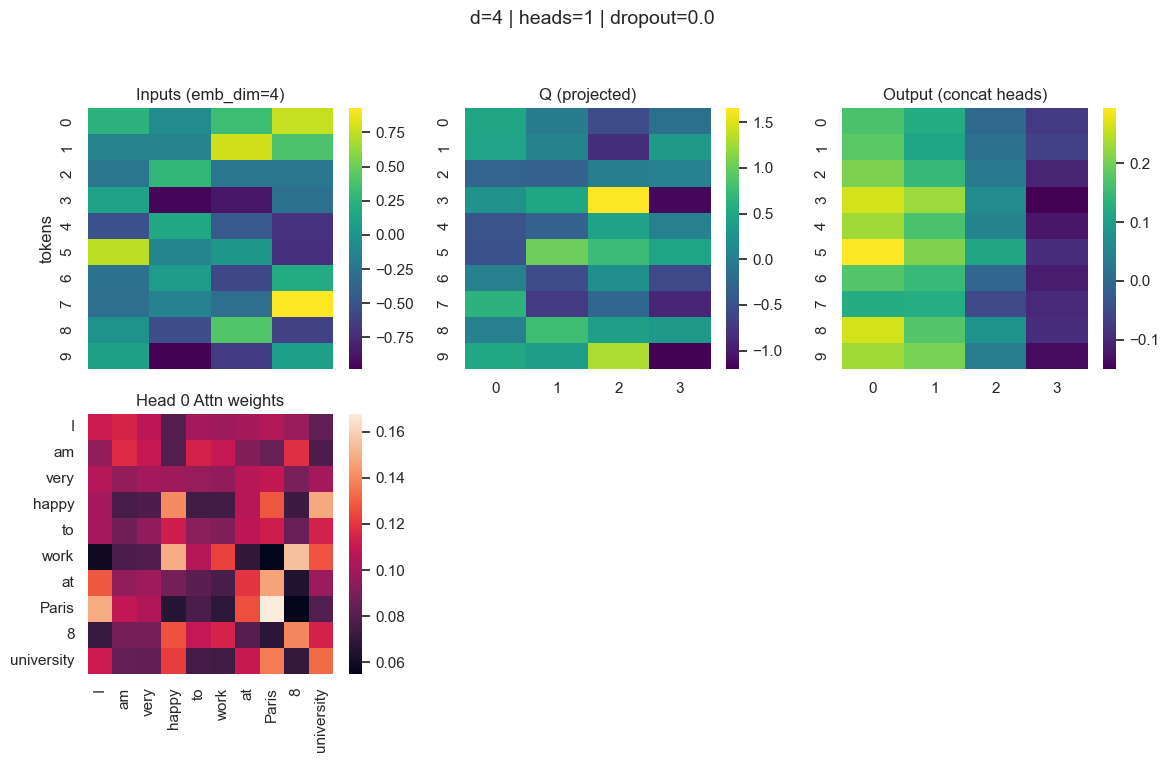

Output shape: (10, 4)
Sum of attention rows (head 0): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

--- d=4 | heads=1 | dropout=0.2


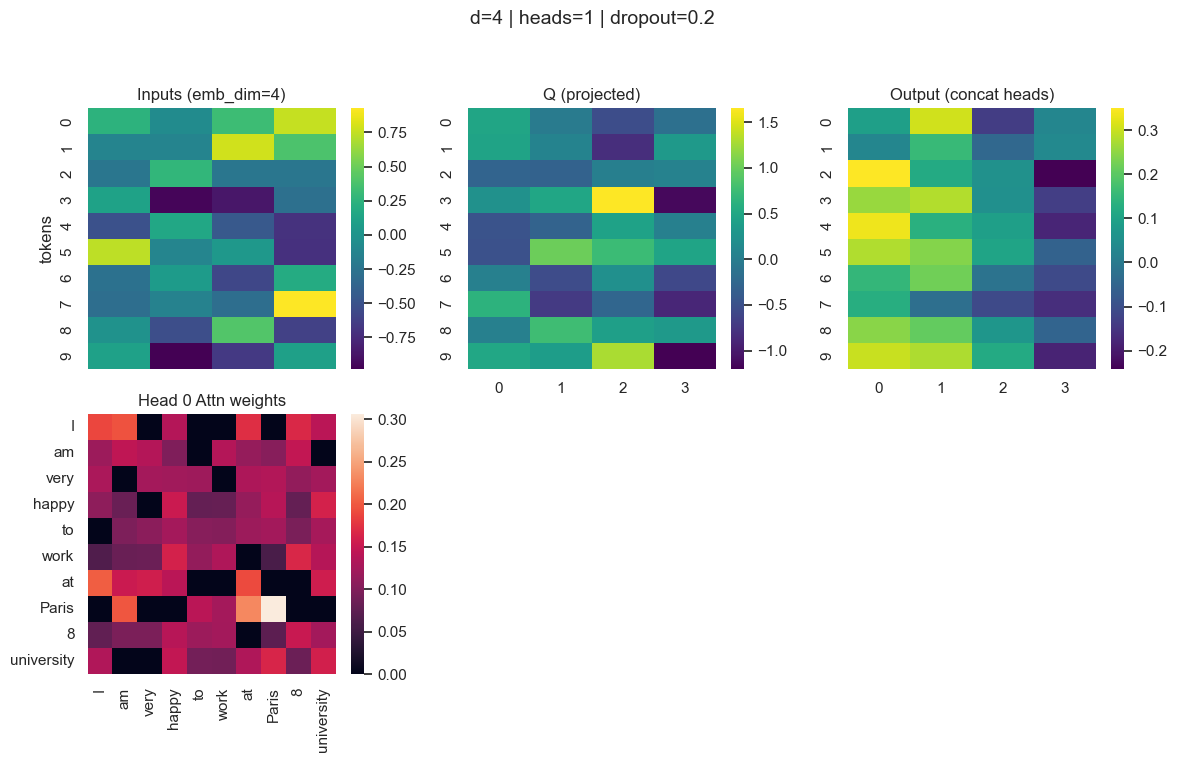

Output shape: (10, 4)
Sum of attention rows (head 0): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

--- d=4 | heads=2 | dropout=0.0


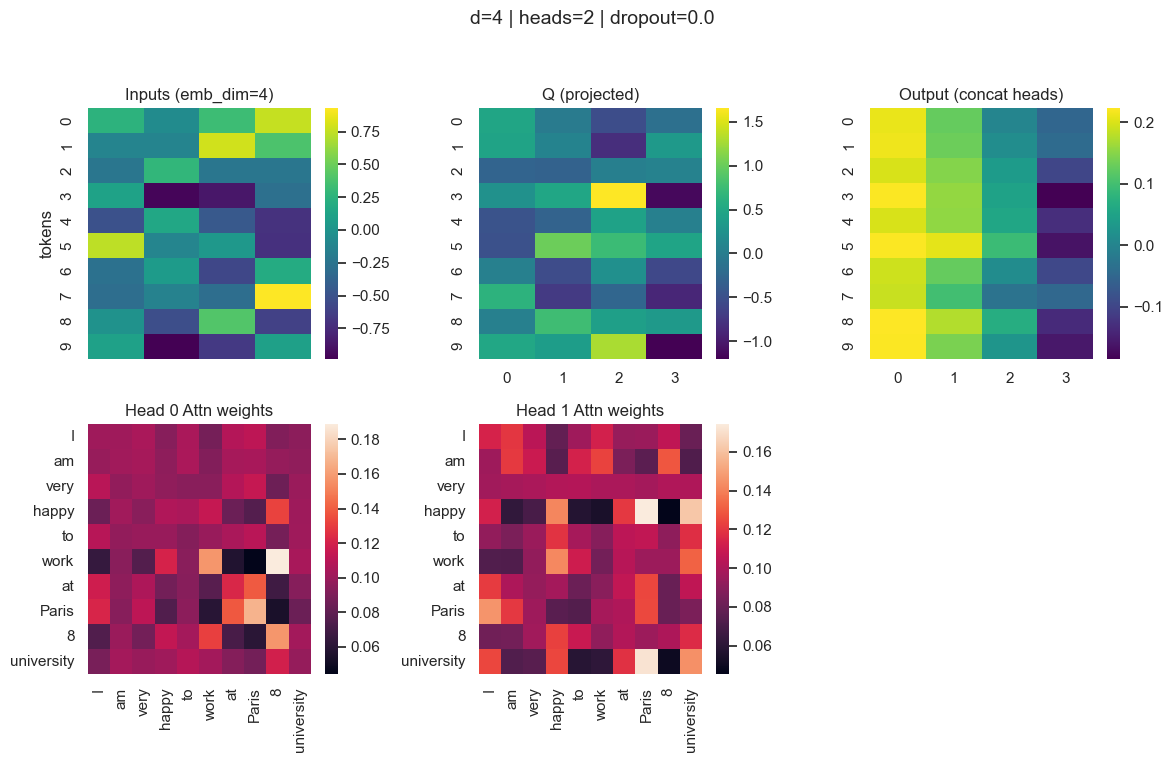

Output shape: (10, 4)
Sum of attention rows (head 0): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

--- d=4 | heads=2 | dropout=0.2


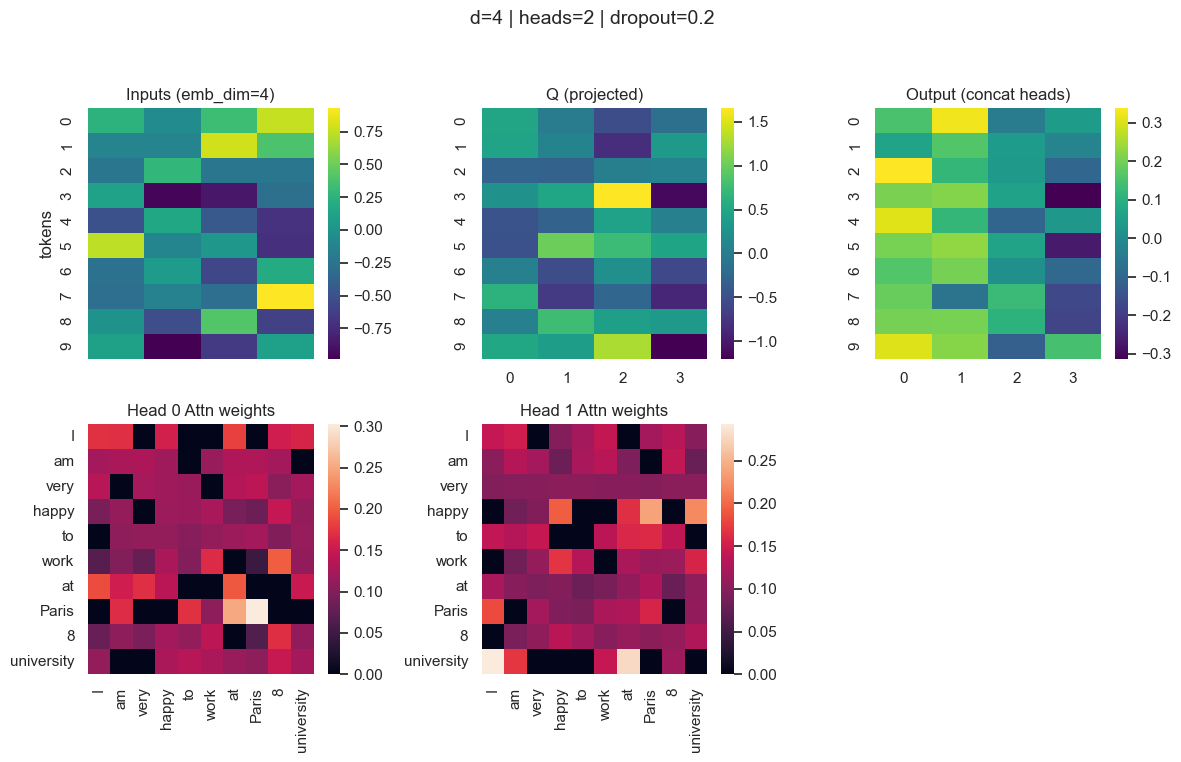

Output shape: (10, 4)
Sum of attention rows (head 0): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

--- d=4 | heads=4 | dropout=0.0


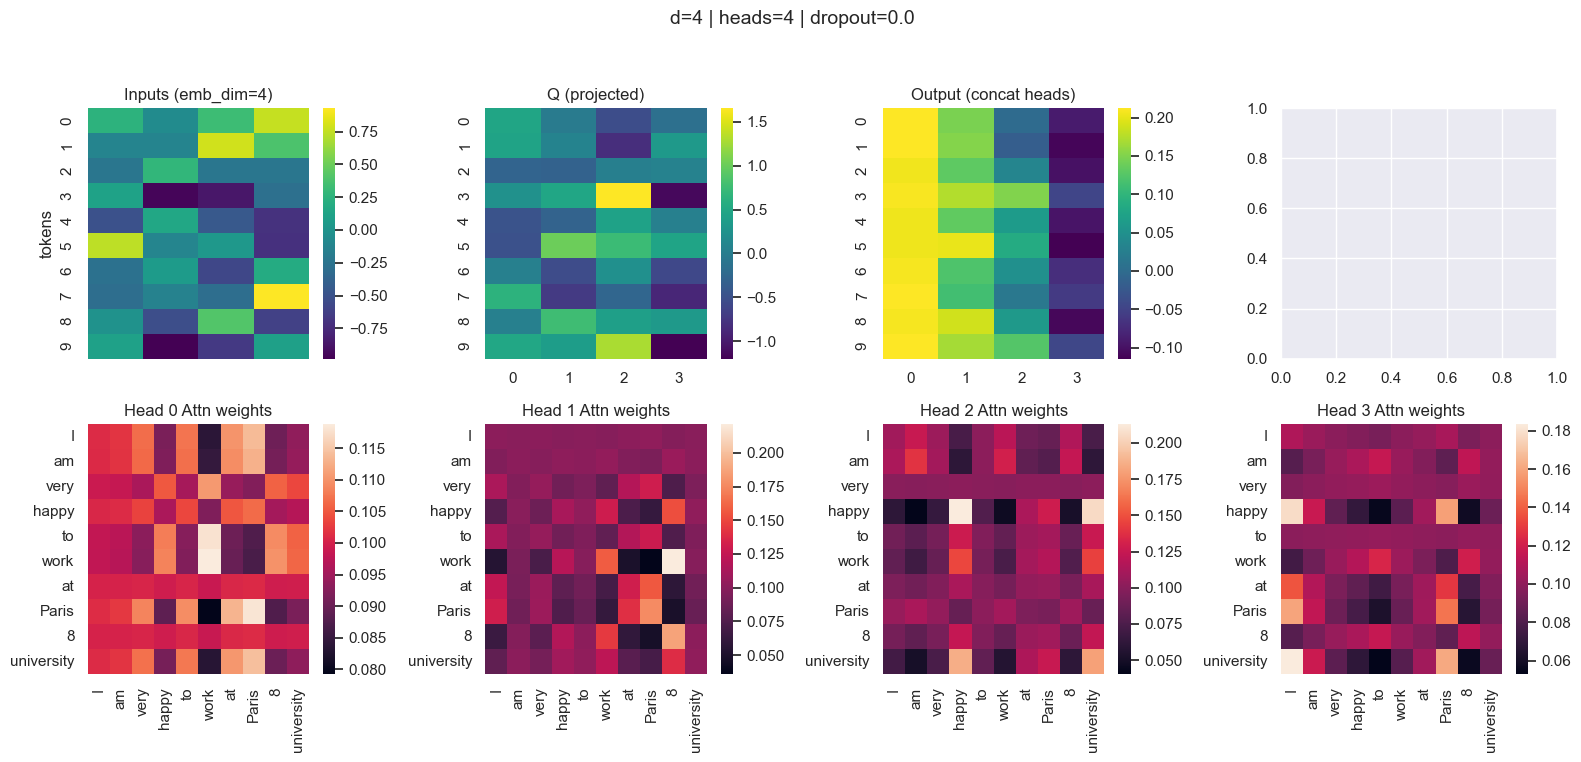

Output shape: (10, 4)
Sum of attention rows (head 0): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

--- d=4 | heads=4 | dropout=0.2


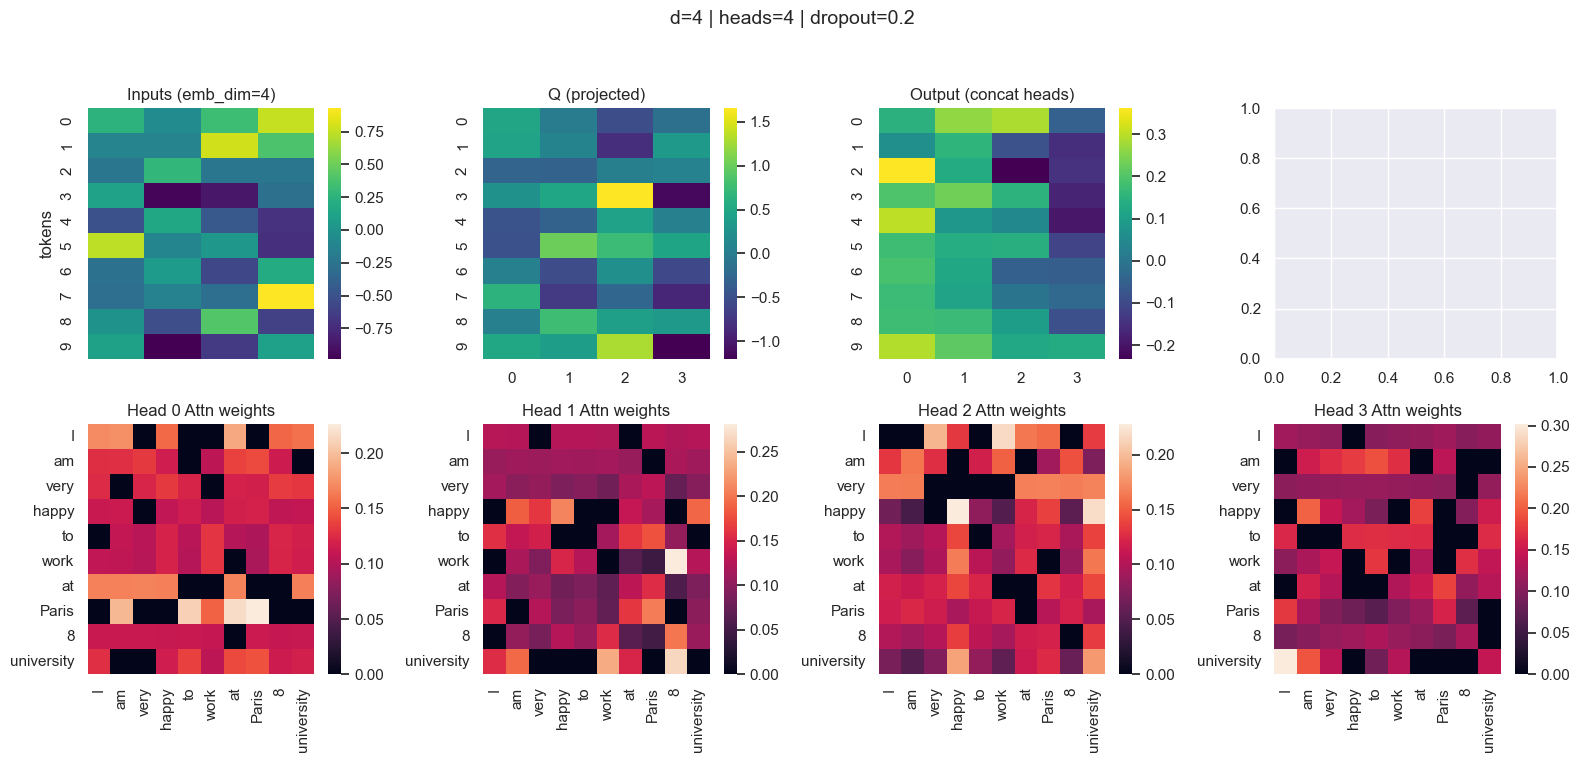

Output shape: (10, 4)
Sum of attention rows (head 0): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


=== EMBEDDING DIMENSION = 8 ===

--- d=8 | heads=1 | dropout=0.0


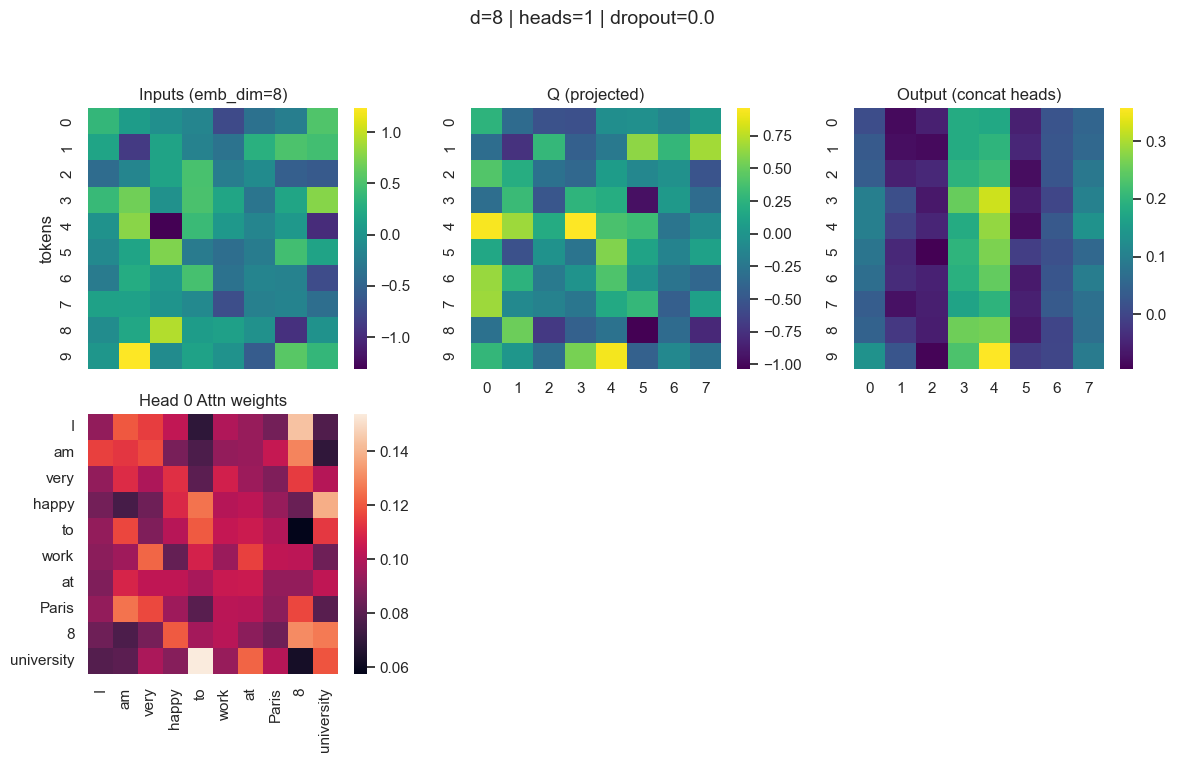

Output shape: (10, 8)
Sum of attention rows (head 0): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

--- d=8 | heads=1 | dropout=0.2


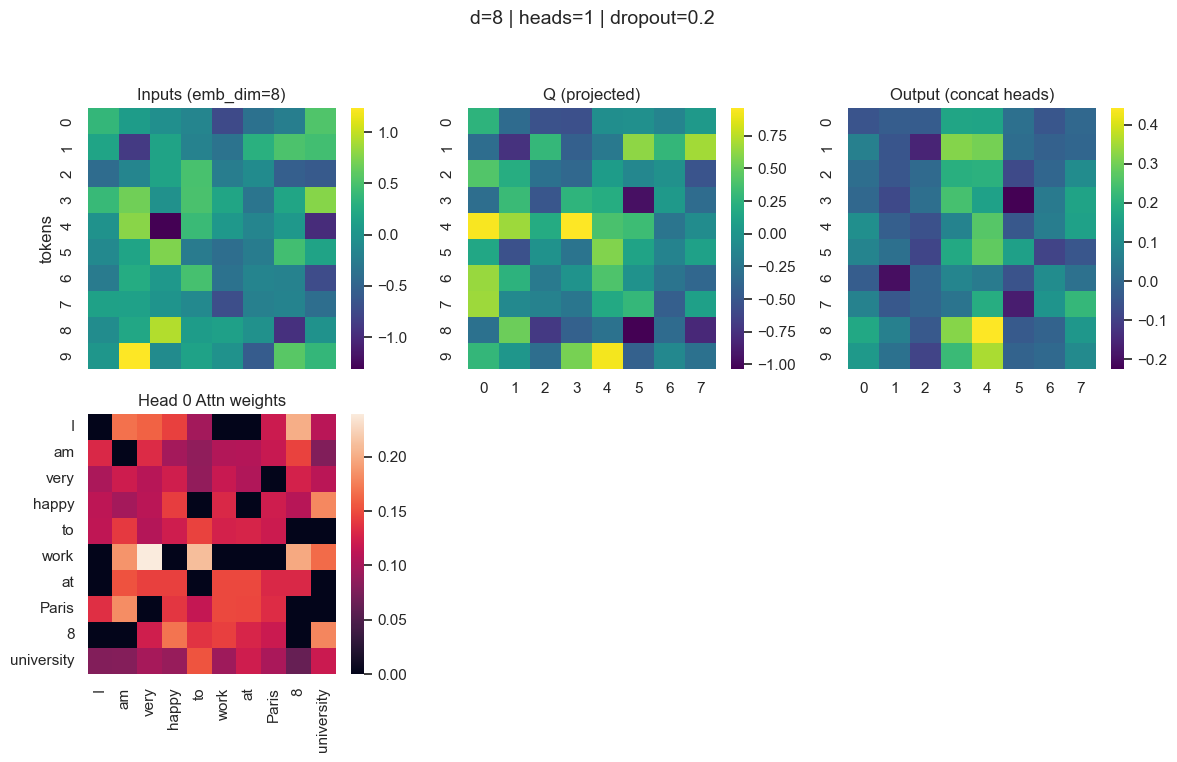

Output shape: (10, 8)
Sum of attention rows (head 0): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

--- d=8 | heads=2 | dropout=0.0


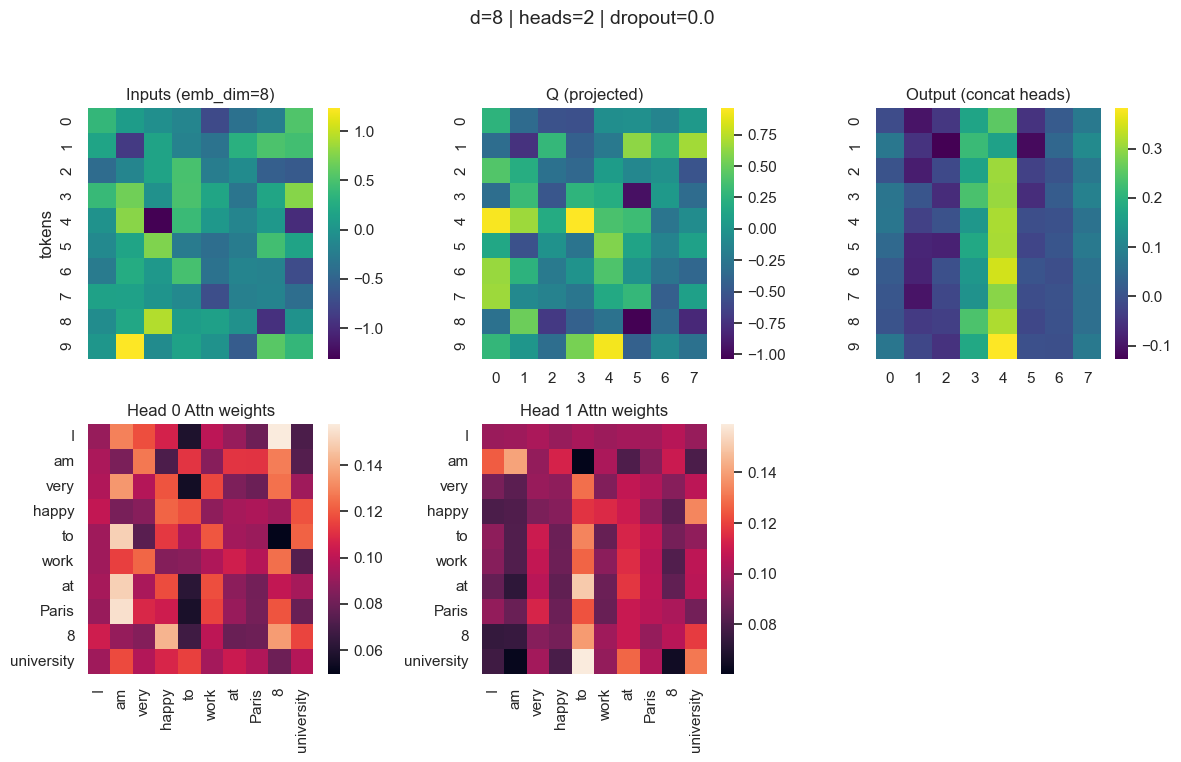

Output shape: (10, 8)
Sum of attention rows (head 0): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

--- d=8 | heads=2 | dropout=0.2


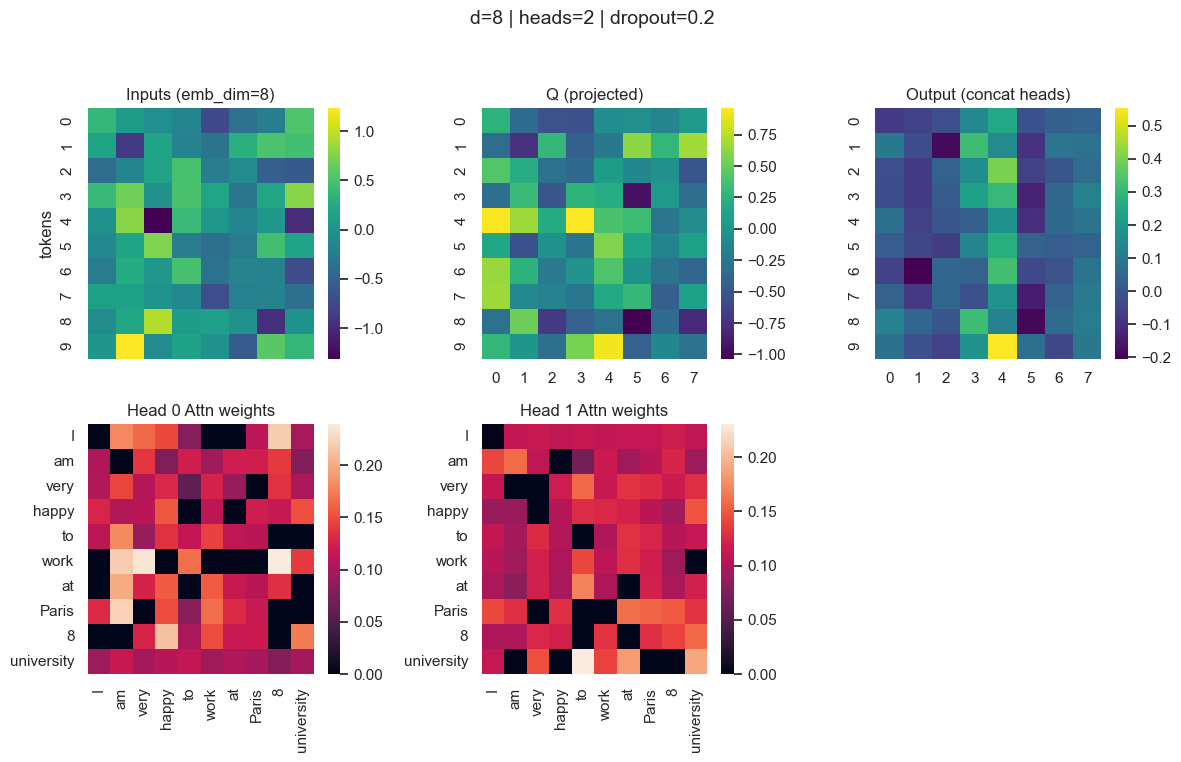

Output shape: (10, 8)
Sum of attention rows (head 0): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

--- d=8 | heads=4 | dropout=0.0


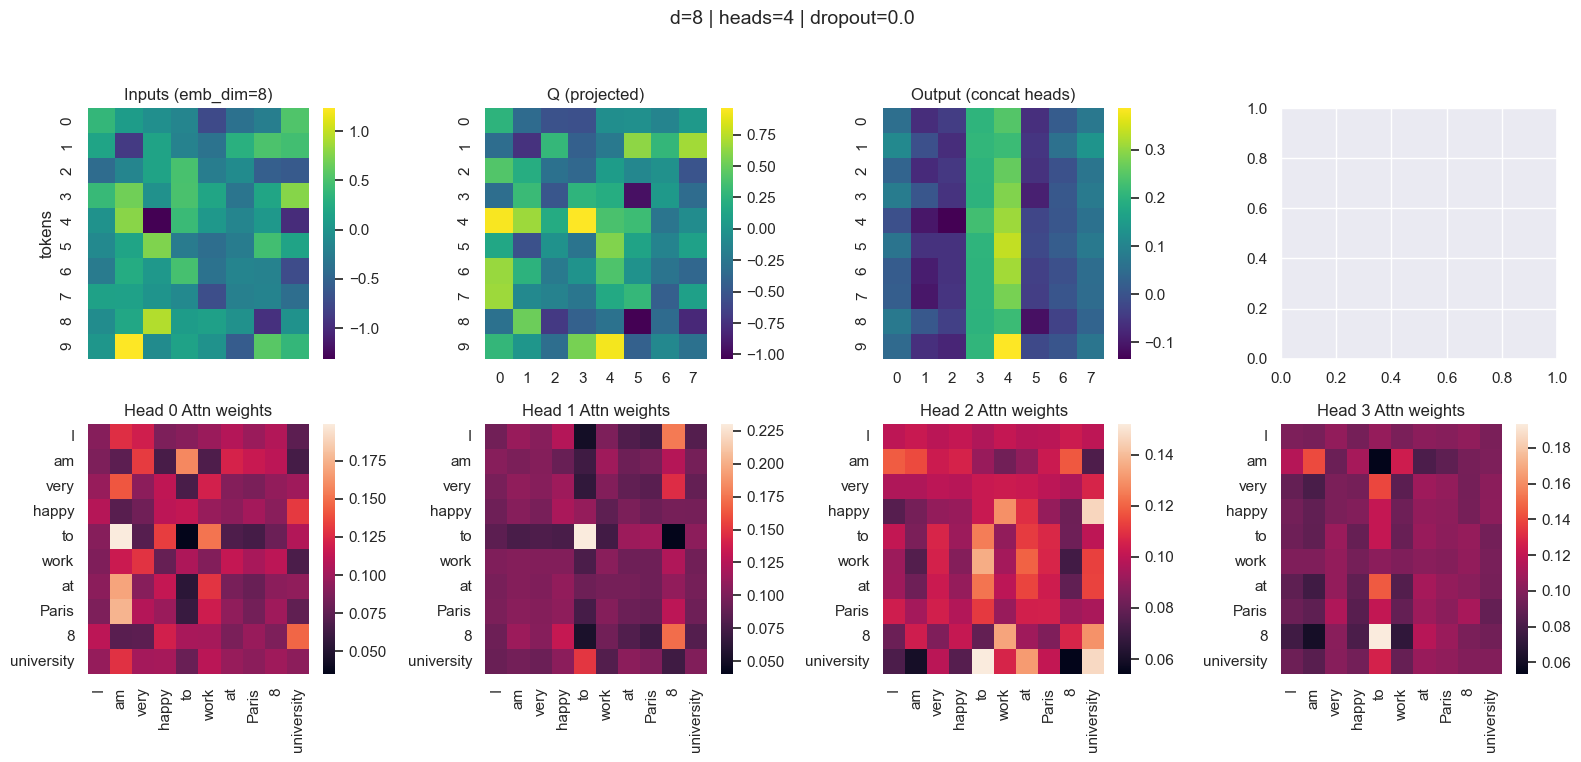

Output shape: (10, 8)
Sum of attention rows (head 0): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

--- d=8 | heads=4 | dropout=0.2


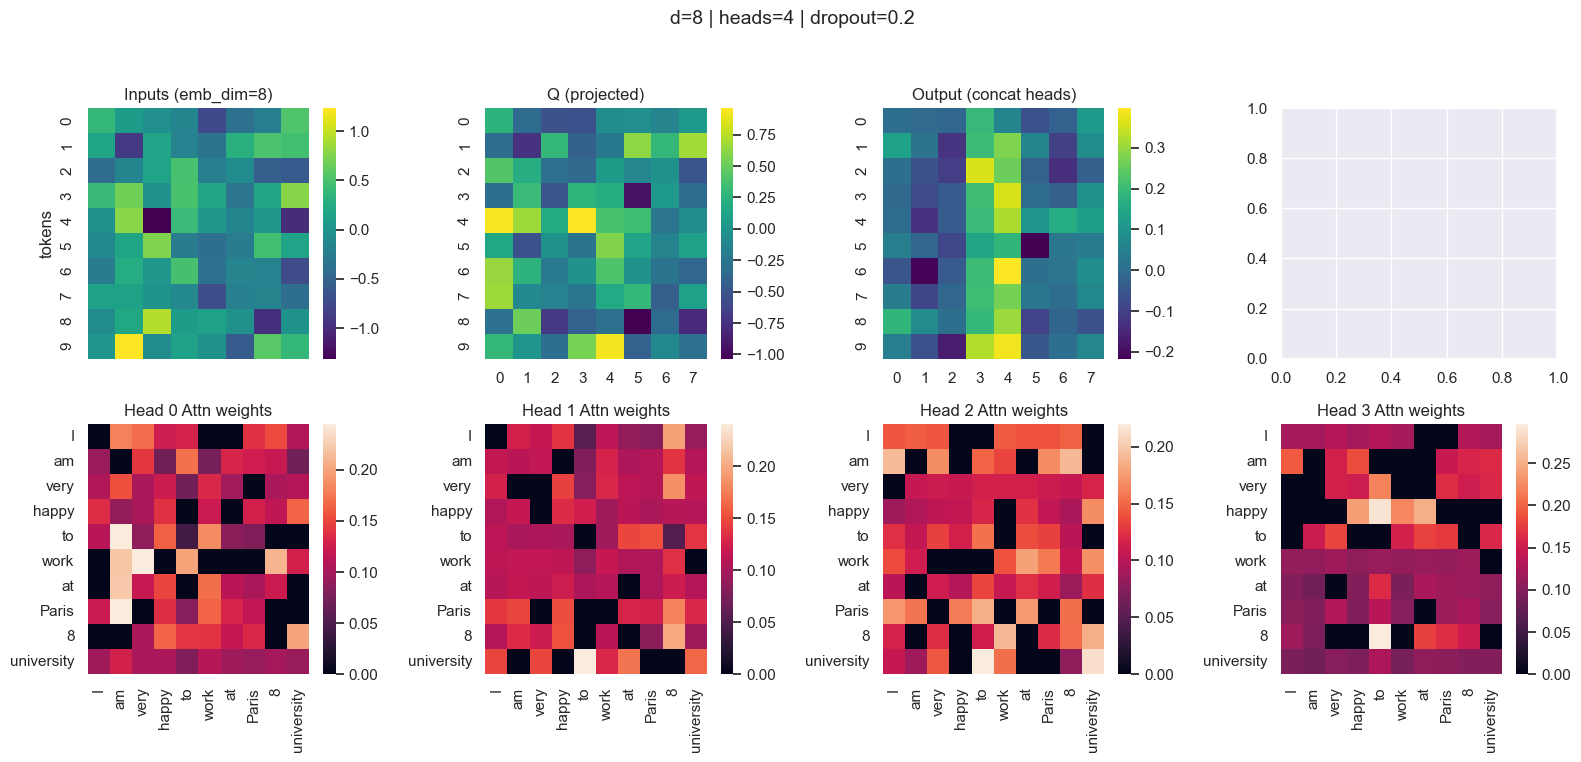

Output shape: (10, 8)
Sum of attention rows (head 0): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


=== EMBEDDING DIMENSION = 16 ===

--- d=16 | heads=1 | dropout=0.0


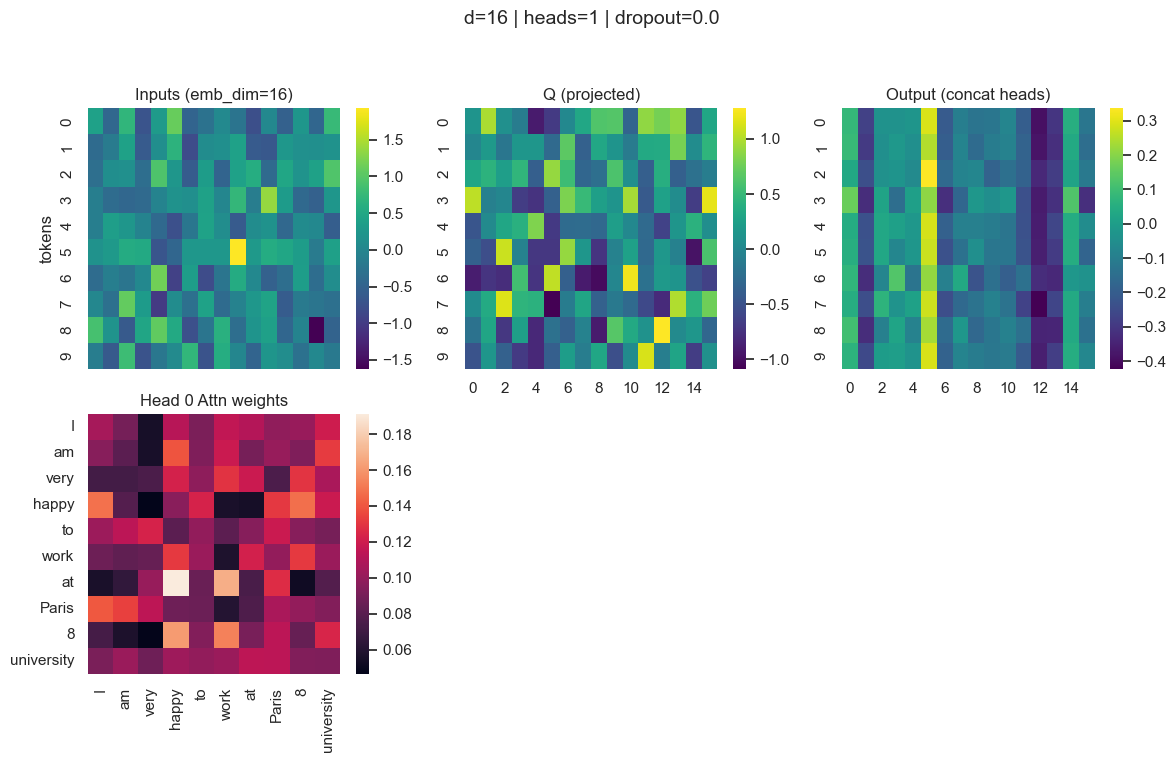

Output shape: (10, 16)
Sum of attention rows (head 0): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

--- d=16 | heads=1 | dropout=0.2


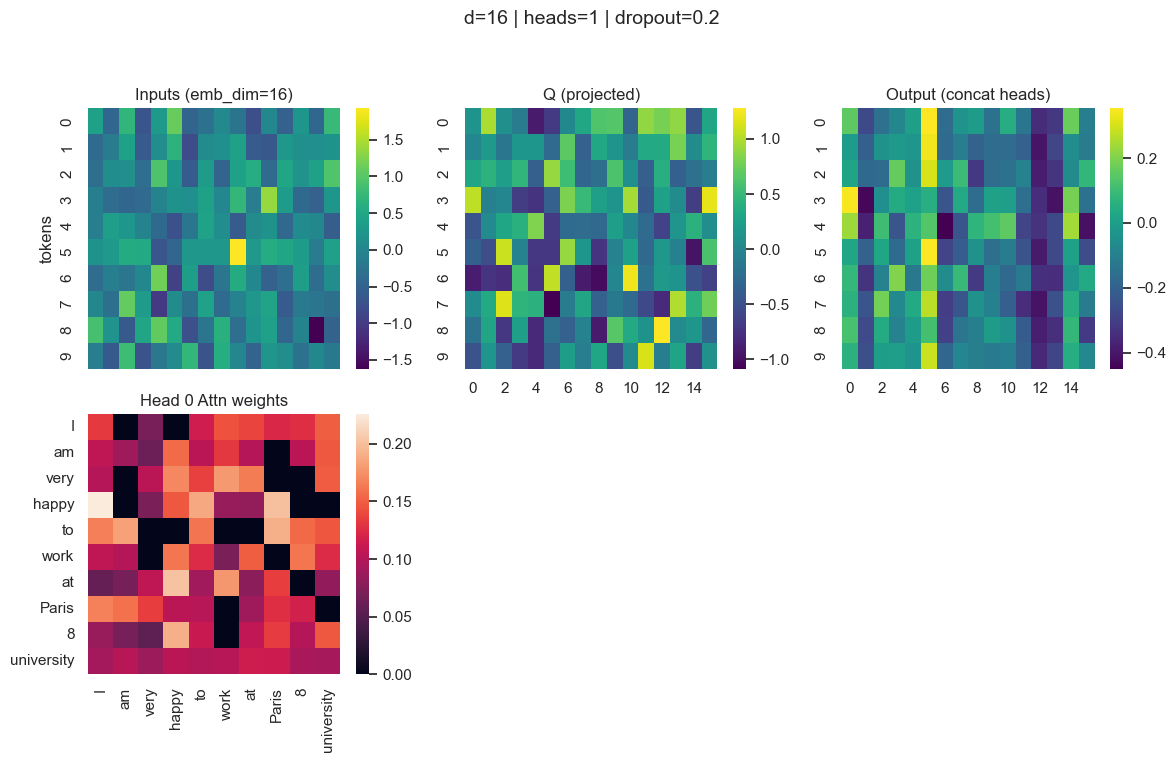

Output shape: (10, 16)
Sum of attention rows (head 0): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

--- d=16 | heads=2 | dropout=0.0


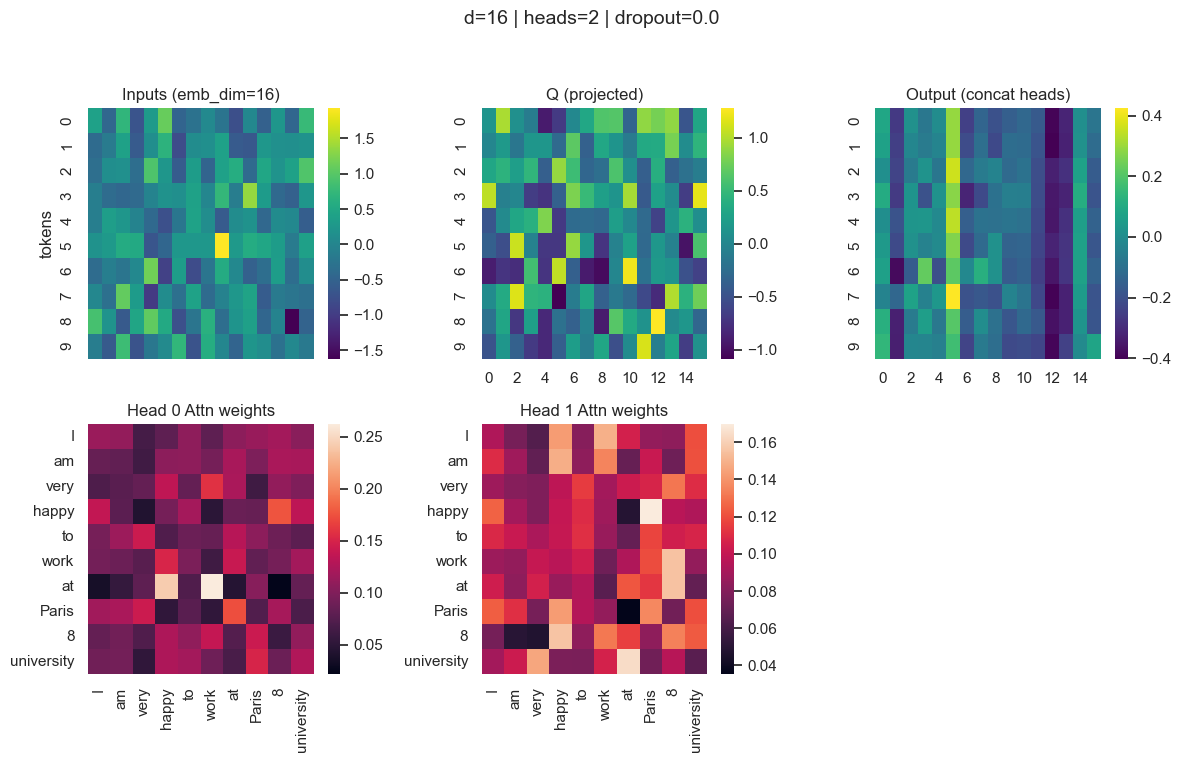

Output shape: (10, 16)
Sum of attention rows (head 0): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

--- d=16 | heads=2 | dropout=0.2


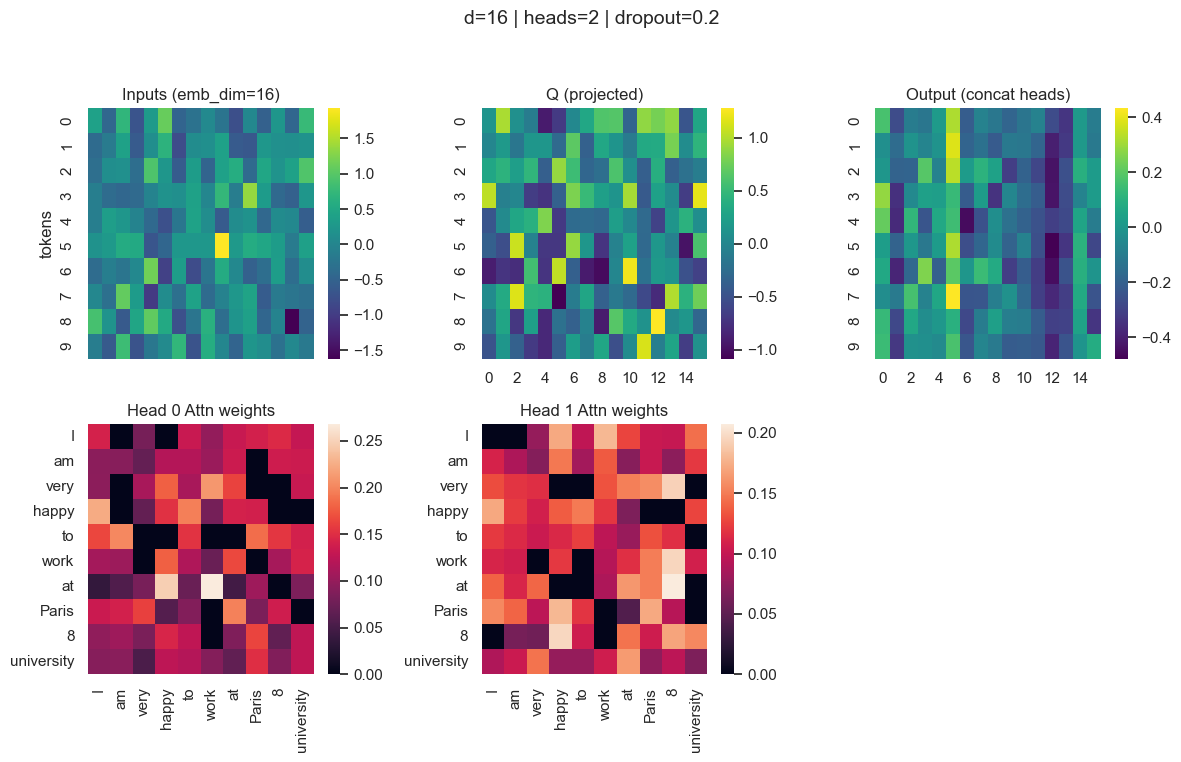

Output shape: (10, 16)
Sum of attention rows (head 0): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

--- d=16 | heads=4 | dropout=0.0


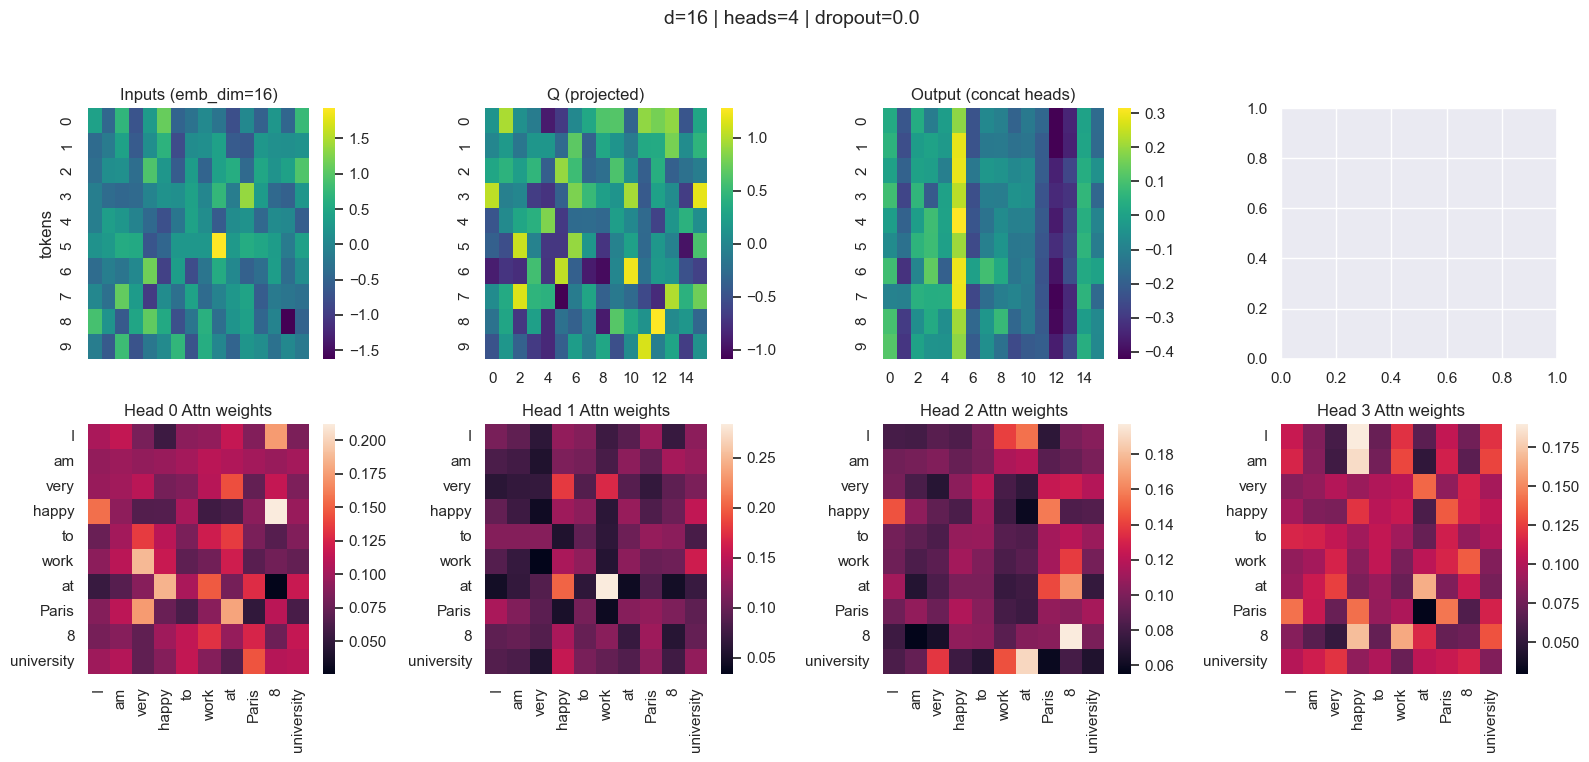

Output shape: (10, 16)
Sum of attention rows (head 0): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

--- d=16 | heads=4 | dropout=0.2


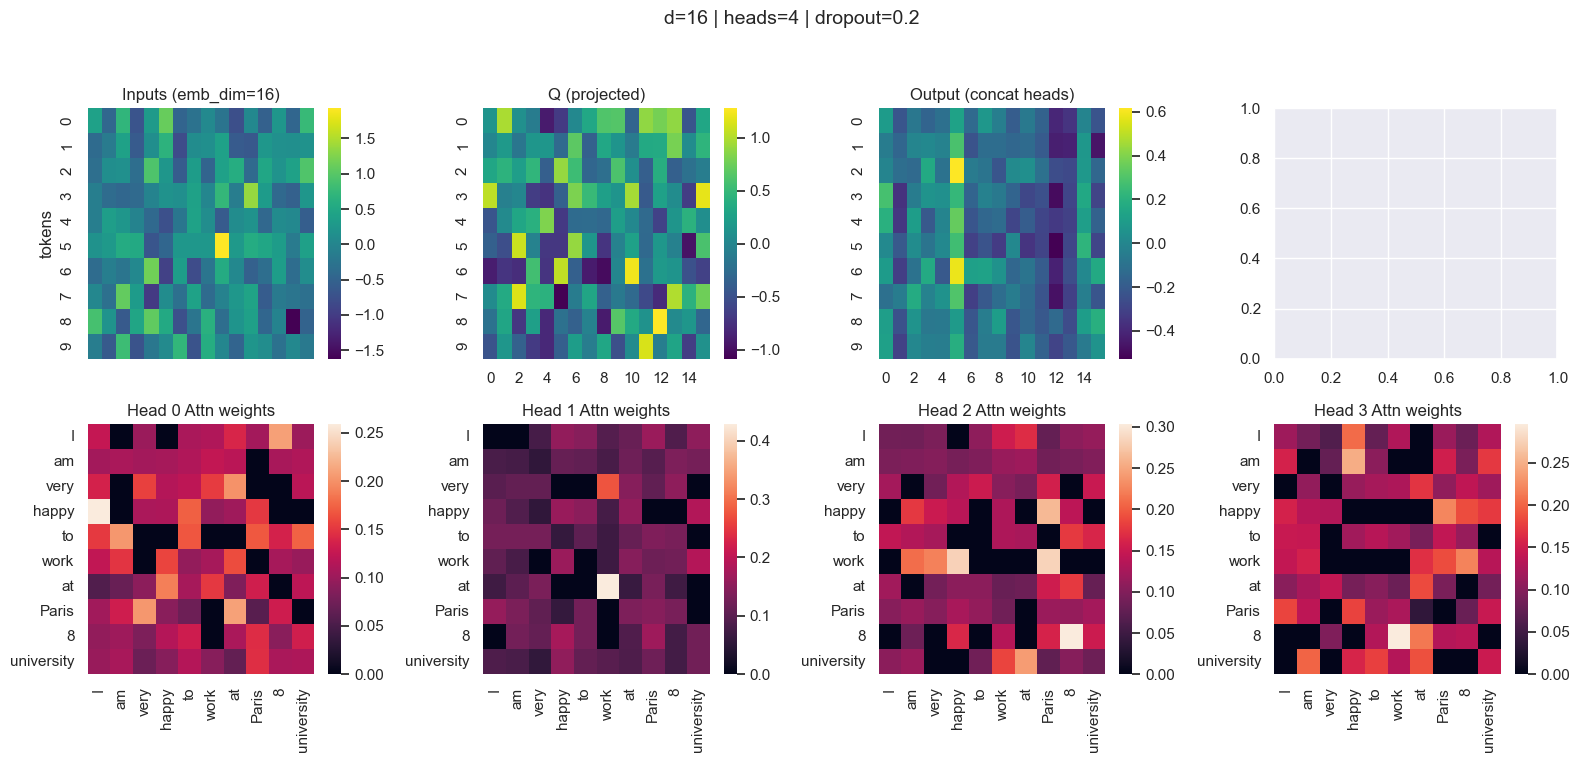

Output shape: (10, 16)
Sum of attention rows (head 0): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()  

def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    exp = np.exp(x)
    return exp / np.sum(exp, axis=axis, keepdims=True)

def stable_layer_norm(x, eps=1e-6):
    mean = np.mean(x, axis=-1, keepdims=True)
    std = np.std(x, axis=-1, keepdims=True)
    return (x - mean) / (std + eps)

def xavier_init(in_dim, out_dim, rng):
    limit = np.sqrt(6.0 / (in_dim + out_dim))
    return rng.uniform(-limit, limit, size=(in_dim, out_dim))


def multi_head_attention(inputs, d_model=None, num_heads=1, dropout=0.0, seed=0, scaling_factor=None):
    rng = np.random.RandomState(seed)
    seq_len, embed_dim = inputs.shape
    if d_model is None:
        d_model = embed_dim
    assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
    depth = d_model // num_heads  # dim per head

    # Linear projections: Wq, Wk, Wv map embed_dim -> d_model
    Wq = xavier_init(embed_dim, d_model, rng)
    Wk = xavier_init(embed_dim, d_model, rng)
    Wv = xavier_init(embed_dim, d_model, rng)

    Q = inputs.dot(Wq)   # (seq_len, d_model)
    K = inputs.dot(Wk)
    V = inputs.dot(Wv)

    # split heads: reshape to (num_heads, seq_len, depth)
    def split_heads(x):
        x = x.reshape(seq_len, num_heads, depth)   # (seq_len, heads, depth)
        x = np.transpose(x, (1, 0, 2))             # (heads, seq_len, depth)
        return x

    Qh = split_heads(Q)
    Kh = split_heads(K)
    Vh = split_heads(V)

    # compute scores per head: (heads, seq_len, seq_len)
    scores = np.matmul(Qh, np.transpose(Kh, (0, 2, 1)))  # (heads, seq_len, seq_len)

    # scaling
    if scaling_factor is None:
        scaling_factor = np.sqrt(depth).astype(float)
    scores = scores / scaling_factor

    # softmax -> attention weights
    attn = np.empty_like(scores)
    for h in range(num_heads):
        attn[h] = softmax(scores[h], axis=-1)

    # apply dropout on attention weights if requested (then renormalize rows)
    if dropout and dropout > 0.0:
        keep_prob = 1.0 - dropout
        mask = rng.binomial(1, keep_prob, size=attn.shape).astype(float)
        attn = attn * mask
        # renormalize rows (avoid div by zero)
        row_sums = attn.sum(axis=-1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        attn = attn / row_sums

    # weighted sum: (heads, seq_len, depth) = attn (heads, seq_len, seq_len) @ Vh (heads, seq_len, depth)
    head_outputs = np.matmul(attn, Vh)  # (heads, seq_len, depth)

    # concat heads -> (seq_len, d_model)
    head_outputs = np.transpose(head_outputs, (1, 0, 2))  # (seq_len, heads, depth)
    concat = head_outputs.reshape(seq_len, d_model)

    # final output (no final linear here for simplicity)
    output = concat

    return {
        "Q": Q, "K": K, "V": V,
        "attn_per_head": attn,
        "output": output,
        "scores": scores
    }

# Experiment runner + visualization
def run_experiments(sentence, embedding_dims=[4,8,16], heads_list=[1,2,4], dropout_rates=[0.0, 0.2], seed=0):
    seq_len = len(sentence)
    rng = np.random.RandomState(seed)

    for emb_dim in embedding_dims:
        print(f"\n\n=== EMBEDDING DIMENSION = {emb_dim} ===")
        # create random embeddings for each token (seq_len x emb_dim)
        inputs = rng.normal(scale=0.5, size=(seq_len, emb_dim))

        for num_heads in heads_list:
            if emb_dim % num_heads != 0:
                print(f" skip heads={num_heads} cause emb_dim {emb_dim} not divisible by heads")
                continue

            for dropout in dropout_rates:
                tag = f"d={emb_dim} | heads={num_heads} | dropout={dropout}"
                print("\n---", tag)

                res = multi_head_attention(inputs, d_model=emb_dim, num_heads=num_heads, dropout=dropout, seed=seed)

                # Visualize attention weights for each head (first row of heads if many)
                heads = res["attn_per_head"]
                output = res["output"]

                # Plot heatmaps: for up to 4 heads show all; else show first 4
                H = heads.shape[0]
                show_H = min(H, 4)
                fig, axes = plt.subplots(2, max(3, show_H), figsize=(4*max(3, show_H), 8))
                # top-left: inputs heatmap
                ax0 = axes[0,0]
                sns.heatmap(inputs, ax=ax0, cmap='viridis', cbar=True)
                ax0.set_title(f"Inputs (emb_dim={emb_dim})")
                ax0.set_ylabel("tokens")
                ax0.set_xticks([])

                # top-middle: Q matrix (reshaped)
                ax1 = axes[0,1]
                sns.heatmap(res["Q"], ax=ax1, cmap='viridis')
                ax1.set_title("Q (projected)")

                # top-right: output
                ax2 = axes[0,2]
                sns.heatmap(output, ax=ax2, cmap='viridis')
                ax2.set_title("Output (concat heads)")

                # second row: attention per head
                for h in range(show_H):
                    ax = axes[1, h]
                    sns.heatmap(heads[h], annot=False, cmap='rocket', xticklabels=sentence, yticklabels=sentence, ax=ax)
                    ax.set_title(f"Head {h} Attn weights")

                # if fewer heads than columns, clear extra axes
                if show_H < axes.shape[1]:
                    for j in range(show_H, axes.shape[1]):
                        axes[1, j].axis('off')

                plt.suptitle(tag, fontsize=14)
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()

                # Print small diagnostics
                print("Output shape:", output.shape)
                print("Sum of attention rows (head 0):", np.sum(heads[0], axis=-1))


sentence = "I am very happy to work at Paris 8 university".split()
run_experiments(sentence,
                embedding_dims=[4, 8, 16],
                heads_list=[1, 2, 4],
                dropout_rates=[0.0, 0.2],
                seed=42)


# Exercice 5: Self-Attention mechanism: Advanced Techniques


PARTIE 1: LAYER NORMALIZATION COMPARISON


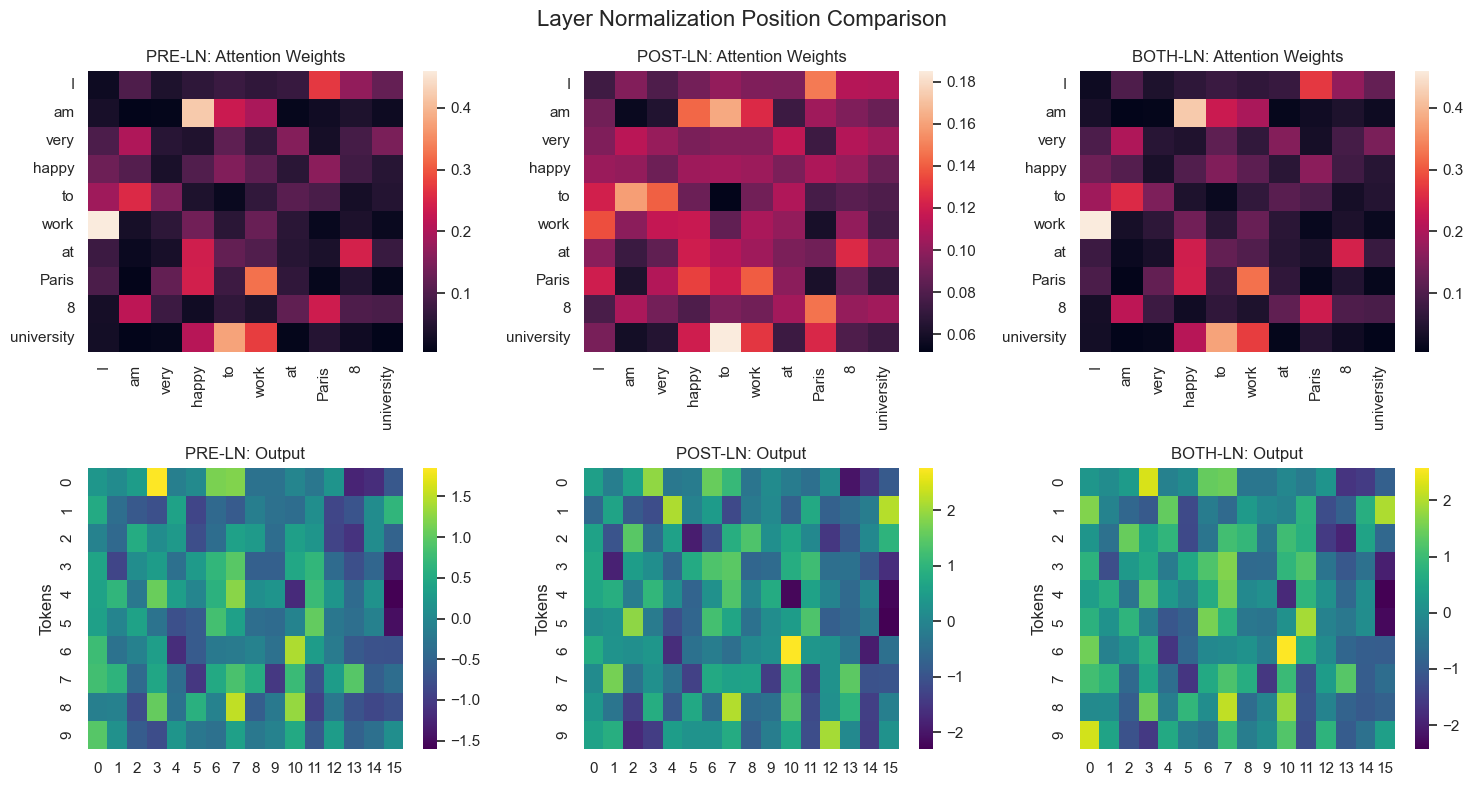


Statistics:
PRE-LN: mean=-0.0685, std=0.6428
POST-LN: mean=-0.0000, std=1.0000
BOTH-LN: mean=0.0000, std=1.0000

PARTIE 2: ACTIVATION FUNCTIONS COMPARISON
ReLU: mean=0.0514, std=0.5427, min=-1.2208, max=1.6297
Leaky ReLU: mean=0.0511, std=0.5427, min=-1.2222, max=1.6326
ELU: mean=0.0256, std=0.6430, min=-1.3981, max=1.7676
GELU: mean=0.0342, std=0.4625, min=-1.0138, max=1.3188


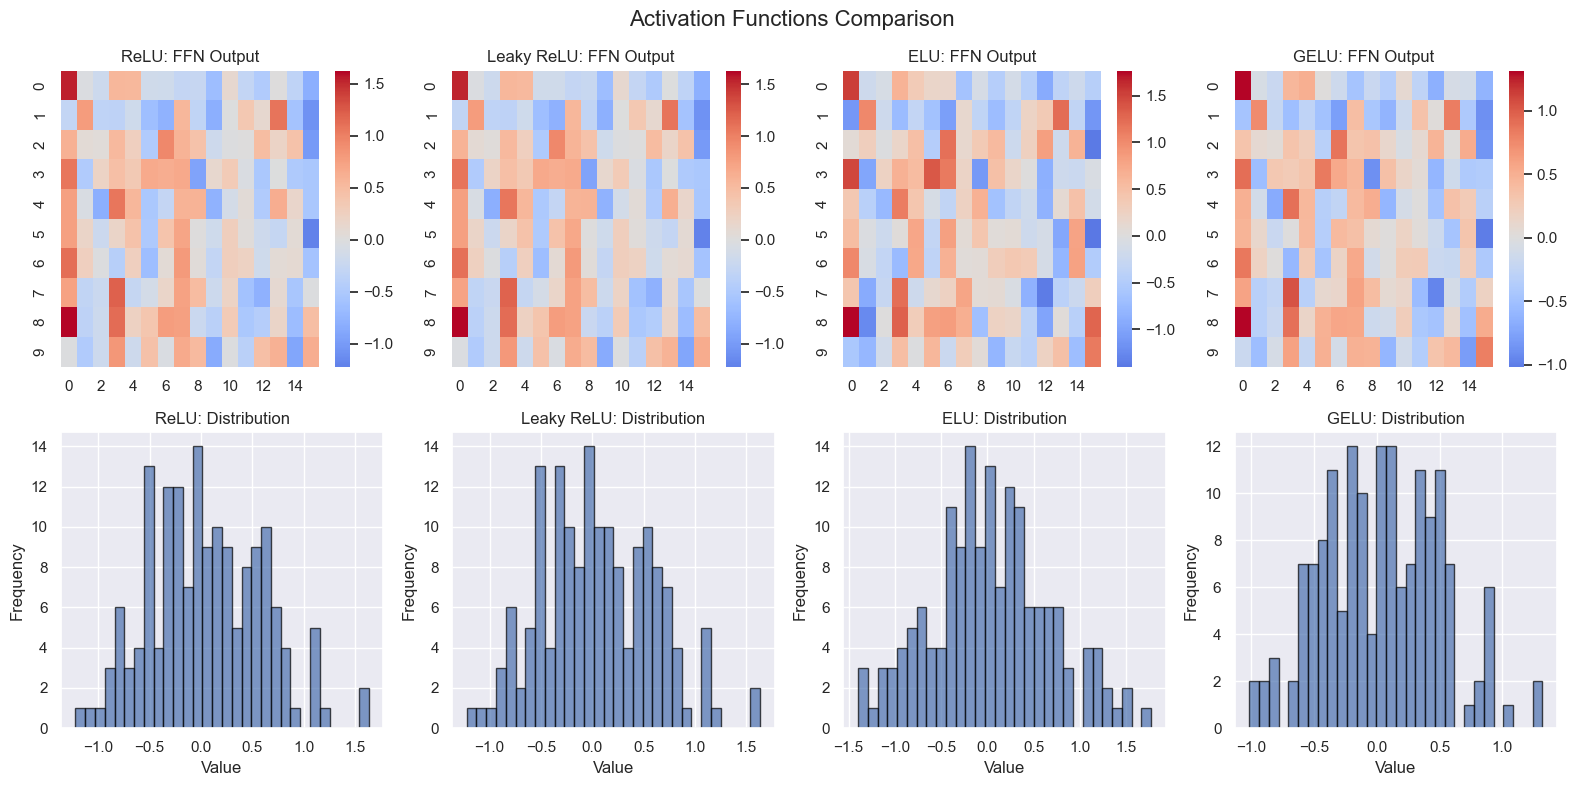


PARTIE 3: MASKING FOR VARIABLE-LENGTH SEQUENCES
Sentence: ['I', 'am', 'very', 'happy', 'to', 'work', 'at', 'Paris', '8', 'university']
Mask (True=valid, False=padding): [ True  True  True  True  True  True  True False False False]


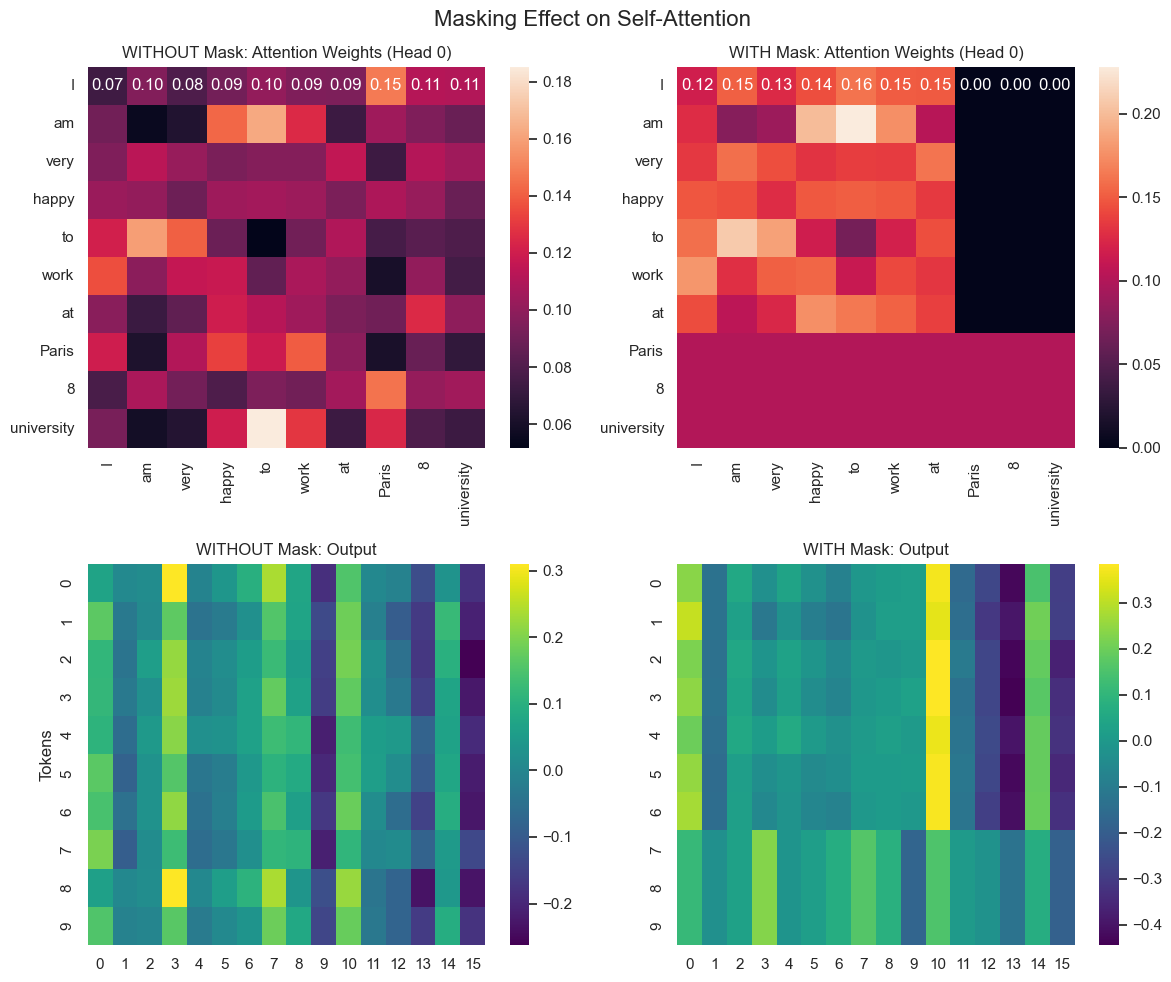


Attention to padding tokens (last 3 positions):
Without mask: 0.2882
With mask: 0.0900

ALL EXPERIMENTS COMPLETED


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    exp = np.exp(x)
    return exp / np.sum(exp, axis=axis, keepdims=True)

def stable_layer_norm(x, eps=1e-6):
    """Layer normalization"""
    mean = np.mean(x, axis=-1, keepdims=True)
    std = np.std(x, axis=-1, keepdims=True)
    return (x - mean) / (std + eps)

def xavier_init(in_dim, out_dim, rng):
    limit = np.sqrt(6.0 / (in_dim + out_dim))
    return rng.uniform(-limit, limit, size=(in_dim, out_dim))

# PARTIE 1: Layer Normalization

def multi_head_attention_with_ln(inputs, d_model=None, num_heads=1, dropout=0.0, 
                                  seed=0, layer_norm_position='post'):
    """
    Multi-head attention with layer normalization
    layer_norm_position: 'pre', 'post', or 'both'
    """
    rng = np.random.RandomState(seed)
    seq_len, embed_dim = inputs.shape
    if d_model is None:
        d_model = embed_dim
    assert d_model % num_heads == 0
    depth = d_model // num_heads

    # Pre-LayerNorm
    if layer_norm_position in ['pre', 'both']:
        inputs_normalized = stable_layer_norm(inputs)
    else:
        inputs_normalized = inputs

    # Projections
    Wq = xavier_init(embed_dim, d_model, rng)
    Wk = xavier_init(embed_dim, d_model, rng)
    Wv = xavier_init(embed_dim, d_model, rng)

    Q = inputs_normalized.dot(Wq)
    K = inputs_normalized.dot(Wk)
    V = inputs_normalized.dot(Wv)

    def split_heads(x):
        x = x.reshape(seq_len, num_heads, depth)
        x = np.transpose(x, (1, 0, 2))
        return x

    Qh = split_heads(Q)
    Kh = split_heads(K)
    Vh = split_heads(V)

    scores = np.matmul(Qh, np.transpose(Kh, (0, 2, 1)))
    scores = scores / np.sqrt(depth)

    attn = np.empty_like(scores)
    for h in range(num_heads):
        attn[h] = softmax(scores[h], axis=-1)

    if dropout > 0.0:
        keep_prob = 1.0 - dropout
        mask = rng.binomial(1, keep_prob, size=attn.shape).astype(float)
        attn = attn * mask
        row_sums = attn.sum(axis=-1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        attn = attn / row_sums

    head_outputs = np.matmul(attn, Vh)
    head_outputs = np.transpose(head_outputs, (1, 0, 2))
    concat = head_outputs.reshape(seq_len, d_model)

    # Residual connection
    output = concat + inputs

    # Post-LayerNorm
    if layer_norm_position in ['post', 'both']:
        output = stable_layer_norm(output)

    return {"attn_per_head": attn, "output": output, "input": inputs}


# PARTIE 2: Different Activation Functions

def relu(x):
    return np.maximum(0, x)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def elu(x, alpha=1.0):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

def gelu(x):
    """Approximation de GELU"""
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

def feed_forward_layer(x, activation_fn, seed=0):
    """Feed-forward layer with configurable activation"""
    rng = np.random.RandomState(seed)
    d_model = x.shape[-1]
    d_ff = d_model * 4  # typical expansion factor
    
    W1 = xavier_init(d_model, d_ff, rng)
    b1 = np.zeros(d_ff)
    W2 = xavier_init(d_ff, d_model, rng)
    b2 = np.zeros(d_model)
    
    # First layer + activation
    hidden = activation_fn(x.dot(W1) + b1)
    # Second layer
    output = hidden.dot(W2) + b2
    
    return output


# PARTIE 3: Masking for Variable-Length Sequences

def multi_head_attention_with_mask(inputs, mask=None, d_model=None, num_heads=1, seed=0):
    """
    Multi-head attention with padding mask
    mask: boolean array of shape (seq_len,) where True = valid token, False = padding
    """
    rng = np.random.RandomState(seed)
    seq_len, embed_dim = inputs.shape
    if d_model is None:
        d_model = embed_dim
    assert d_model % num_heads == 0
    depth = d_model // num_heads

    Wq = xavier_init(embed_dim, d_model, rng)
    Wk = xavier_init(embed_dim, d_model, rng)
    Wv = xavier_init(embed_dim, d_model, rng)

    Q = inputs.dot(Wq)
    K = inputs.dot(Wk)
    V = inputs.dot(Wv)

    def split_heads(x):
        x = x.reshape(seq_len, num_heads, depth)
        x = np.transpose(x, (1, 0, 2))
        return x

    Qh = split_heads(Q)
    Kh = split_heads(K)
    Vh = split_heads(V)

    scores = np.matmul(Qh, np.transpose(Kh, (0, 2, 1)))
    scores = scores / np.sqrt(depth)

    # Apply mask: set scores to -inf where mask is False
    if mask is not None:
        # mask shape: (seq_len,) -> expand to (1, seq_len, seq_len)
        mask_expanded = mask[None, :, None] & mask[None, None, :]
        mask_expanded = np.broadcast_to(mask_expanded, (num_heads, seq_len, seq_len))
        scores = np.where(mask_expanded, scores, -1e9)

    attn = np.empty_like(scores)
    for h in range(num_heads):
        attn[h] = softmax(scores[h], axis=-1)

    head_outputs = np.matmul(attn, Vh)
    head_outputs = np.transpose(head_outputs, (1, 0, 2))
    concat = head_outputs.reshape(seq_len, d_model)

    return {"attn_per_head": attn, "output": concat, "scores": scores}

# EXPERIMENTS


def experiment_layer_norm(sentence, embed_dim=16, num_heads=2, seed=42):
    """Partie 1: Comparer Pre-LN, Post-LN et Both-LN"""
    print("\n" + "="*60)
    print("PARTIE 1: LAYER NORMALIZATION COMPARISON")
    print("="*60)
    
    seq_len = len(sentence)
    rng = np.random.RandomState(seed)
    inputs = rng.normal(scale=0.5, size=(seq_len, embed_dim))
    
    positions = ['pre', 'post', 'both']
    results = {}
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    for idx, pos in enumerate(positions):
        res = multi_head_attention_with_ln(inputs, d_model=embed_dim, num_heads=num_heads, 
                                           layer_norm_position=pos, seed=seed)
        results[pos] = res
        
        # Plot attention weights (head 0)
        ax = axes[0, idx]
        sns.heatmap(res['attn_per_head'][0], annot=False, cmap='rocket', 
                   xticklabels=sentence, yticklabels=sentence, ax=ax)
        ax.set_title(f"{pos.upper()}-LN: Attention Weights")
        
        # Plot output
        ax = axes[1, idx]
        sns.heatmap(res['output'], cmap='viridis', ax=ax)
        ax.set_title(f"{pos.upper()}-LN: Output")
        ax.set_ylabel("Tokens")
    
    plt.suptitle("Layer Normalization Position Comparison", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print("\nStatistics:")
    for pos in positions:
        output = results[pos]['output']
        print(f"{pos.upper()}-LN: mean={output.mean():.4f}, std={output.std():.4f}")

def experiment_activations(sentence, embed_dim=16, num_heads=2, seed=42):
    """Partie 2: Comparer différentes fonctions d'activation"""
    print("\n" + "="*60)
    print("PARTIE 2: ACTIVATION FUNCTIONS COMPARISON")
    print("="*60)
    
    seq_len = len(sentence)
    rng = np.random.RandomState(seed)
    inputs = rng.normal(scale=0.5, size=(seq_len, embed_dim))
    
    # Get attention output first
    res = multi_head_attention_with_ln(inputs, d_model=embed_dim, num_heads=num_heads, seed=seed)
    attn_output = res['output']
    
    activations = {
        'ReLU': relu,
        'Leaky ReLU': leaky_relu,
        'ELU': elu,
        'GELU': gelu
    }
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    for idx, (name, act_fn) in enumerate(activations.items()):
        ff_output = feed_forward_layer(attn_output, act_fn, seed=seed)
        
        # Plot FFN output
        ax = axes[0, idx]
        sns.heatmap(ff_output, cmap='coolwarm', center=0, ax=ax)
        ax.set_title(f"{name}: FFN Output")
        
        # Plot distribution
        ax = axes[1, idx]
        ax.hist(ff_output.flatten(), bins=30, alpha=0.7, edgecolor='black')
        ax.set_title(f"{name}: Distribution")
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")
        
        print(f"{name}: mean={ff_output.mean():.4f}, std={ff_output.std():.4f}, "
              f"min={ff_output.min():.4f}, max={ff_output.max():.4f}")
    
    plt.suptitle("Activation Functions Comparison", fontsize=16)
    plt.tight_layout()
    plt.show()

def experiment_masking(sentence, embed_dim=16, num_heads=2, seed=42):
    """Partie 3: Démontrer l'effet du masking"""
    print("\n" + "="*60)
    print("PARTIE 3: MASKING FOR VARIABLE-LENGTH SEQUENCES")
    print("="*60)
    
    seq_len = len(sentence)
    rng = np.random.RandomState(seed)
    inputs = rng.normal(scale=0.5, size=(seq_len, embed_dim))
    
    # Create mask: last 3 tokens are padding
    mask = np.array([True] * (seq_len - 3) + [False] * 3)
    print(f"Sentence: {sentence}")
    print(f"Mask (True=valid, False=padding): {mask}")
    
    # Without mask
    res_no_mask = multi_head_attention_with_mask(inputs, mask=None, d_model=embed_dim, 
                                                  num_heads=num_heads, seed=seed)
    
    # With mask
    res_with_mask = multi_head_attention_with_mask(inputs, mask=mask, d_model=embed_dim, 
                                                    num_heads=num_heads, seed=seed)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Attention without mask
    ax = axes[0, 0]
    sns.heatmap(res_no_mask['attn_per_head'][0], annot=True, fmt='.2f', cmap='rocket',
               xticklabels=sentence, yticklabels=sentence, ax=ax)
    ax.set_title("WITHOUT Mask: Attention Weights (Head 0)")
    
    # Attention with mask
    ax = axes[0, 1]
    sns.heatmap(res_with_mask['attn_per_head'][0], annot=True, fmt='.2f', cmap='rocket',
               xticklabels=sentence, yticklabels=sentence, ax=ax)
    ax.set_title("WITH Mask: Attention Weights (Head 0)")
    
    # Output without mask
    ax = axes[1, 0]
    sns.heatmap(res_no_mask['output'], cmap='viridis', ax=ax)
    ax.set_title("WITHOUT Mask: Output")
    ax.set_ylabel("Tokens")
    
    # Output with mask
    ax = axes[1, 1]
    sns.heatmap(res_with_mask['output'], cmap='viridis', ax=ax)
    ax.set_title("WITH Mask: Output")
    
    plt.suptitle("Masking Effect on Self-Attention", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Show attention to padding tokens
    print("\nAttention to padding tokens (last 3 positions):")
    print(f"Without mask: {res_no_mask['attn_per_head'][0, :, -3:].sum(axis=1).mean():.4f}")
    print(f"With mask: {res_with_mask['attn_per_head'][0, :, -3:].sum(axis=1).mean():.4f}")


# MAIN EXECUTION

if __name__ == "__main__":
    sentence = "I am very happy to work at Paris 8 university".split()
    
    experiment_layer_norm(sentence, embed_dim=16, num_heads=2, seed=42)
    experiment_activations(sentence, embed_dim=16, num_heads=2, seed=42)
    experiment_masking(sentence, embed_dim=16, num_heads=2, seed=42)
    
    print("\n" + "="*60)
    print("ALL EXPERIMENTS COMPLETED")
    print("="*60)


SELF-ATTENTION MECHANISM: APPLICATIONS

PARTIE 1: NAMED ENTITY RECOGNITION
Sentence: Barack Obama was the 44th president of the United States

Named Entities:
  - Barack: PERSON
  - Obama: PERSON
  - 44th: ORDINAL
  - United: GPE
  - States: GPE


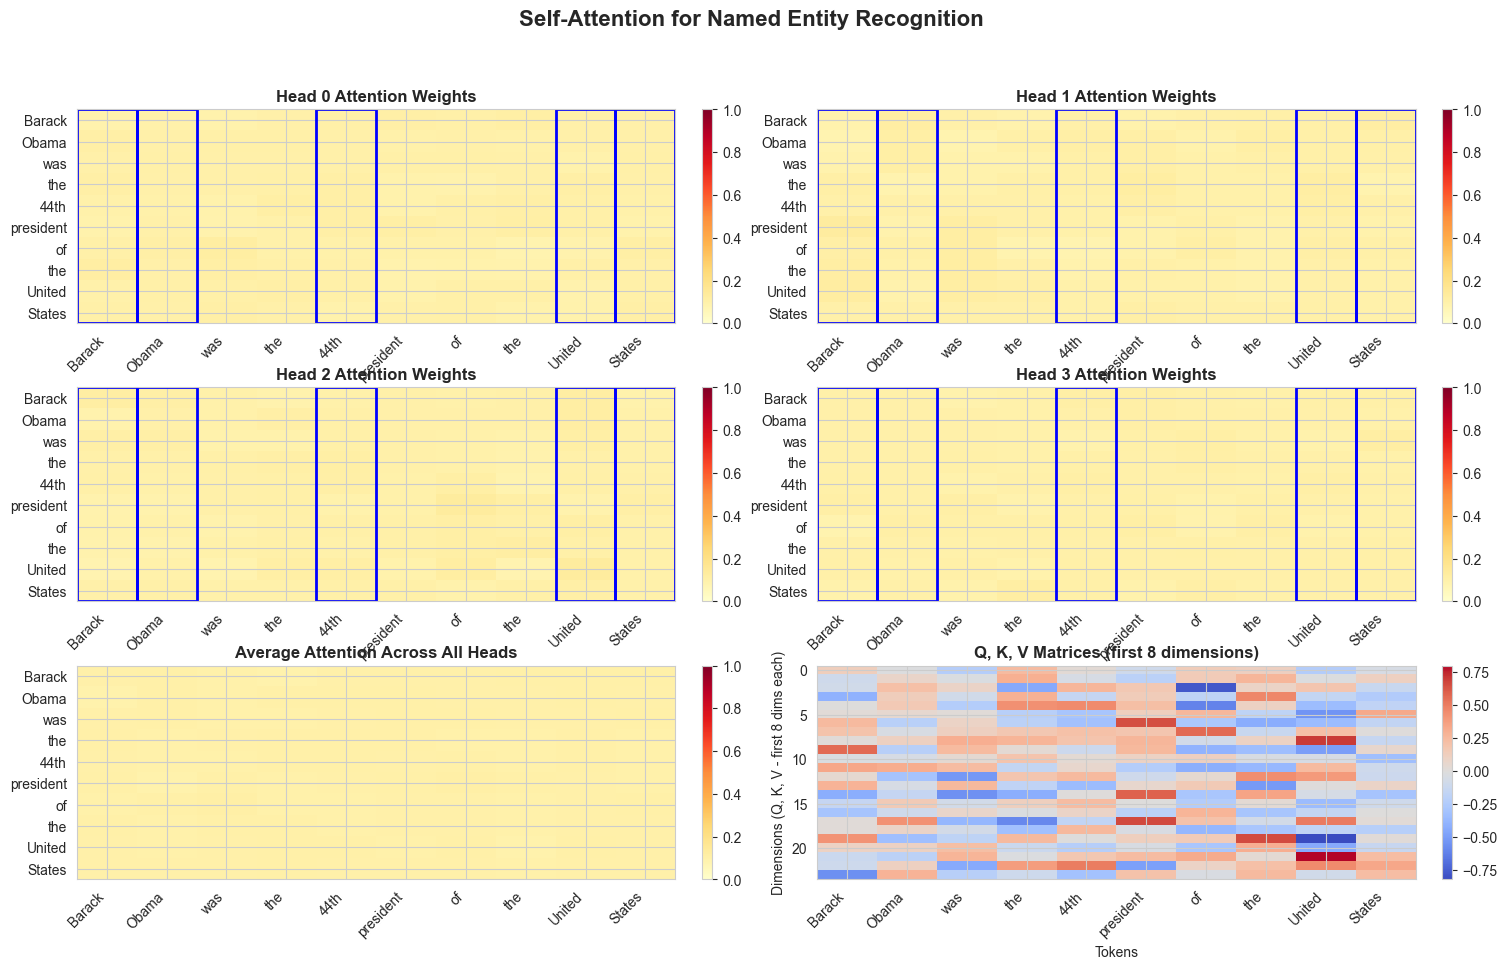


--- Attention Analysis ---

Attention from 'Barack' to other tokens (avg across heads):
  Barack      : 0.0985 ←
  Obama       : 0.1048 ←
  was         : 0.0939
  the         : 0.0926
  44th        : 0.1004 ←
  president   : 0.1011
  of          : 0.0997
  the         : 0.1020
  United      : 0.1049 ←
  States      : 0.1020 ←

Attention from 'president' to other tokens:
  Barack      : 0.1028 ←
  Obama       : 0.0936 ←
  was         : 0.1018
  the         : 0.0965
  44th        : 0.0986 ←
  president   : 0.1017
  of          : 0.1062
  the         : 0.1034
  United      : 0.0983 ←
  States      : 0.0971 ←

PARTIE 2: SEQUENCE-TO-SEQUENCE TRANSLATION
Source (EN): I love machine learning
Target (FR): J' adore l' apprentissage automatique


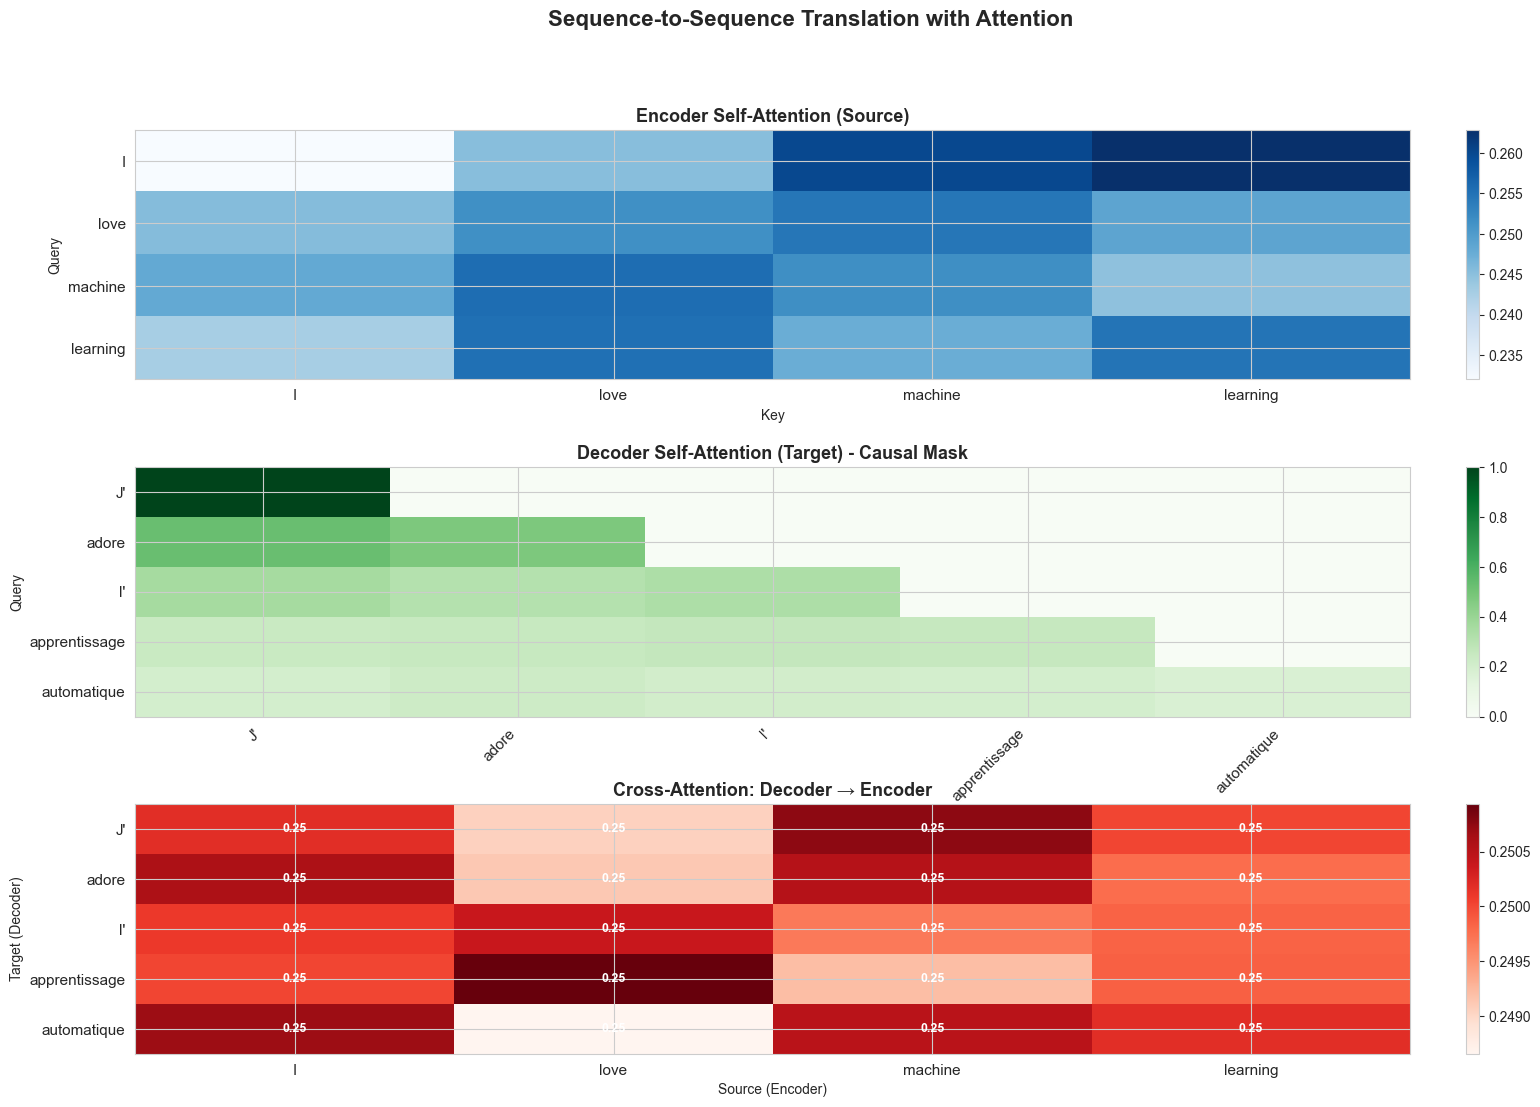


--- Cross-Attention Alignment Analysis ---
J'              → machine         (score: 0.251)
adore           → I               (score: 0.251)
l'              → love            (score: 0.250)
apprentissage   → love            (score: 0.251)
automatique     → I               (score: 0.251)

PARTIE 3: TEXT CLASSIFICATION

--- Sentence 1: POSITIVE ---
This movie is absolutely amazing and wonderful
Top 3 important words for classification:
  - and            : 0.1451
  - wonderful      : 0.1449
  - amazing        : 0.1441

--- Sentence 2: NEGATIVE ---
I hate this terrible and boring film
Top 3 important words for classification:
  - and            : 0.1493
  - terrible       : 0.1448
  - I              : 0.1434

--- Sentence 3: NEUTRAL ---
The product works as expected
Top 3 important words for classification:
  - product        : 0.2165
  - The            : 0.2003
  - expected       : 0.2001

--- Sentence 4: POSITIVE ---
Outstanding performance and great quality
Top 3 important words for c

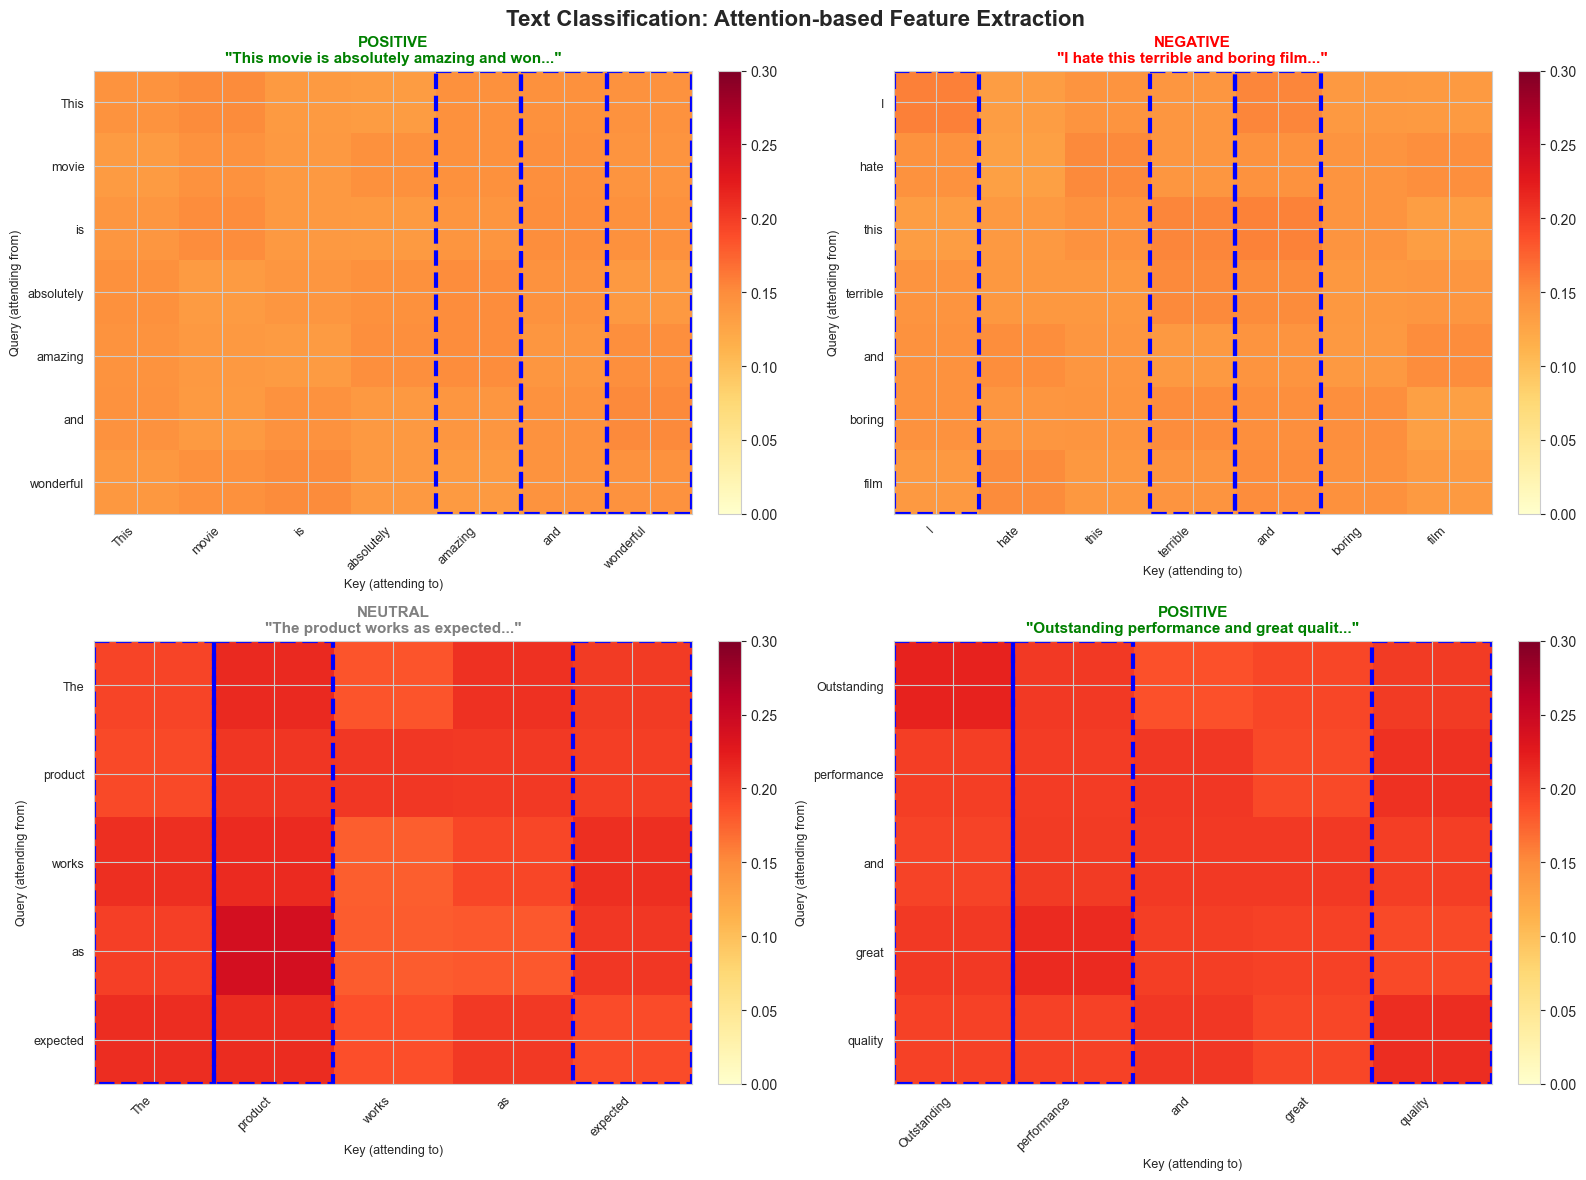


CLASSIFICATION SIMULATION

Using attention-weighted features for classification:
1. Extract attention weights from self-attention
2. Compute weighted average of outputs
3. Use as features for classifier (e.g., softmax layer)

Key insight: Attention helps identify discriminative words
- POSITIVE: focuses on 'amazing', 'wonderful', 'outstanding'
- NEGATIVE: focuses on 'hate', 'terrible', 'boring'
- NEUTRAL: distributes attention more uniformly

ALL EXPERIMENTS COMPLETED

KEY TAKEAWAYS:
1. Named Entities: Self-attention captures relationships between
   entity components (e.g., 'Barack' ↔ 'Obama')
2. Seq2Seq: Cross-attention aligns source and target sequences
   for translation tasks
3. Classification: Attention identifies important words/features
   for discriminative classification


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

sns.set_style("whitegrid")

def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    exp = np.exp(x)
    return exp / np.sum(exp, axis=axis, keepdims=True)

def xavier_init(in_dim, out_dim, rng):
    limit = np.sqrt(6.0 / (in_dim + out_dim))
    return rng.uniform(-limit, limit, size=(in_dim, out_dim))

def create_embeddings(tokens, embed_dim, seed=42):
    """Create embeddings for tokens with some semantic similarity"""
    rng = np.random.RandomState(seed)
    embeddings = rng.normal(0, 0.3, size=(len(tokens), embed_dim))
    return embeddings

def multi_head_attention(inputs, d_model=None, num_heads=1, seed=0, mask=None):
    """Multi-head self-attention mechanism"""
    rng = np.random.RandomState(seed)
    seq_len, embed_dim = inputs.shape
    if d_model is None:
        d_model = embed_dim
    assert d_model % num_heads == 0
    depth = d_model // num_heads

    Wq = xavier_init(embed_dim, d_model, rng)
    Wk = xavier_init(embed_dim, d_model, rng)
    Wv = xavier_init(embed_dim, d_model, rng)

    Q = inputs.dot(Wq)
    K = inputs.dot(Wk)
    V = inputs.dot(Wv)

    def split_heads(x):
        x = x.reshape(seq_len, num_heads, depth)
        x = np.transpose(x, (1, 0, 2))
        return x

    Qh = split_heads(Q)
    Kh = split_heads(K)
    Vh = split_heads(V)

    scores = np.matmul(Qh, np.transpose(Kh, (0, 2, 1)))
    scores = scores / np.sqrt(depth)

    if mask is not None:
        mask_expanded = np.broadcast_to(mask[None, :, :], (num_heads, seq_len, seq_len))
        scores = np.where(mask_expanded, scores, -1e9)

    attn = np.empty_like(scores)
    for h in range(num_heads):
        attn[h] = softmax(scores[h], axis=-1)

    head_outputs = np.matmul(attn, Vh)
    head_outputs = np.transpose(head_outputs, (1, 0, 2))
    concat = head_outputs.reshape(seq_len, d_model)

    return {
        "Q": Q, "K": K, "V": V,
        "attn_per_head": attn,
        "output": concat,
        "scores": scores
    }

# PARTIE 1: Named Entity Recognition

def experiment_named_entities(seed=42):
    """Application 1: Self-attention avec entités nommées"""
    print("\n" + "="*70)
    print("PARTIE 1: NAMED ENTITY RECOGNITION")
    print("="*70)
    
    sentence = "Barack Obama was the 44th president of the United States"
    tokens = sentence.split()
    
    # Annoter les entités nommées
    entity_tags = {
        'Barack': 'PERSON',
        'Obama': 'PERSON',
        '44th': 'ORDINAL',
        'United': 'GPE',
        'States': 'GPE'
    }
    
    print(f"Sentence: {sentence}")
    print(f"\nNamed Entities:")
    for token in tokens:
        if token in entity_tags:
            print(f"  - {token}: {entity_tags[token]}")
    
    embed_dim = 32
    num_heads = 4
    
    # Créer des embeddings avec similarité pour entités liées
    rng = np.random.RandomState(seed)
    embeddings = rng.normal(0, 0.3, size=(len(tokens), embed_dim))
    
    # Ajouter de la similarité entre "Barack" et "Obama"
    embeddings[0] += rng.normal(0, 0.1, embed_dim) * 0.5
    embeddings[1] += rng.normal(0, 0.1, embed_dim) * 0.5
    
    # Similarité entre "United" et "States"
    embeddings[-2] += rng.normal(0, 0.1, embed_dim) * 0.3
    embeddings[-1] += rng.normal(0, 0.1, embed_dim) * 0.3
    
    res = multi_head_attention(embeddings, d_model=embed_dim, num_heads=num_heads, seed=seed)
    
    # Visualisation
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    # Attention weights pour chaque tête
    for h in range(num_heads):
        ax = fig.add_subplot(gs[h // 2, (h % 2) * 2:(h % 2) * 2 + 2])
        attn_matrix = res['attn_per_head'][h]
        
        im = ax.imshow(attn_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
        ax.set_xticks(range(len(tokens)))
        ax.set_yticks(range(len(tokens)))
        ax.set_xticklabels(tokens, rotation=45, ha='right')
        ax.set_yticklabels(tokens)
        ax.set_title(f'Head {h} Attention Weights', fontsize=12, fontweight='bold')
        
        # Ajouter les rectangles pour entités nommées
        for i, token in enumerate(tokens):
            if token in entity_tags:
                rect = Rectangle((i-0.5, -0.5), 1, len(tokens), 
                               linewidth=2, edgecolor='blue', facecolor='none')
                ax.add_patch(rect)
        
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Moyenne des attentions sur toutes les têtes
    ax = fig.add_subplot(gs[2, :2])
    avg_attn = res['attn_per_head'].mean(axis=0)
    im = ax.imshow(avg_attn, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right')
    ax.set_yticklabels(tokens)
    ax.set_title('Average Attention Across All Heads', fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Q, K, V matrices
    ax = fig.add_subplot(gs[2, 2:])
    matrices = np.concatenate([res['Q'][:, :8], res['K'][:, :8], res['V'][:, :8]], axis=1)
    im = ax.imshow(matrices.T, cmap='coolwarm', aspect='auto')
    ax.set_xlabel('Tokens', fontsize=10)
    ax.set_ylabel('Dimensions (Q, K, V - first 8 dims each)', fontsize=10)
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right')
    ax.set_title('Q, K, V Matrices (first 8 dimensions)', fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.suptitle('Self-Attention for Named Entity Recognition', fontsize=16, fontweight='bold')
    plt.show()
    
    # Analyse des relations entre entités
    print("\n--- Attention Analysis ---")
    print("\nAttention from 'Barack' to other tokens (avg across heads):")
    barack_idx = tokens.index('Barack')
    for i, token in enumerate(tokens):
        attn_score = avg_attn[barack_idx, i]
        marker = " ←" if token in entity_tags else ""
        print(f"  {token:12s}: {attn_score:.4f}{marker}")
    
    print("\nAttention from 'president' to other tokens:")
    president_idx = tokens.index('president')
    for i, token in enumerate(tokens):
        attn_score = avg_attn[president_idx, i]
        marker = " ←" if token in entity_tags else ""
        print(f"  {token:12s}: {attn_score:.4f}{marker}")

# PARTIE 2: Sequence-to-Sequence (Translation)

def experiment_seq2seq(seed=42):
    """Application 2: Sequence-to-sequence avec attention encoder-decoder"""
    print("\n" + "="*70)
    print("PARTIE 2: SEQUENCE-TO-SEQUENCE TRANSLATION")
    print("="*70)
    
    # Source (anglais) et cible (français)
    source = "I love machine learning"
    target = "J' adore l' apprentissage automatique"
    
    src_tokens = source.split()
    tgt_tokens = target.split()
    
    print(f"Source (EN): {source}")
    print(f"Target (FR): {target}")
    
    embed_dim = 24
    num_heads = 3
    
    # Embeddings
    src_embeddings = create_embeddings(src_tokens, embed_dim, seed)
    tgt_embeddings = create_embeddings(tgt_tokens, embed_dim, seed + 1)
    
    # Self-attention dans l'encodeur
    encoder_res = multi_head_attention(src_embeddings, d_model=embed_dim, 
                                       num_heads=num_heads, seed=seed)
    
    # Self-attention dans le décodeur (avec masque causal)
    tgt_len = len(tgt_tokens)
    causal_mask = np.tril(np.ones((tgt_len, tgt_len), dtype=bool))
    decoder_self_res = multi_head_attention(tgt_embeddings, d_model=embed_dim,
                                            num_heads=num_heads, seed=seed+1,
                                            mask=causal_mask)
    
    # Cross-attention (decoder vers encoder)
    # Simuler cross-attention: decoder queries × encoder keys
    rng = np.random.RandomState(seed + 2)
    Wq_cross = xavier_init(embed_dim, embed_dim, rng)
    Wk_cross = xavier_init(embed_dim, embed_dim, rng)
    Wv_cross = xavier_init(embed_dim, embed_dim, rng)
    
    Q_cross = tgt_embeddings.dot(Wq_cross)
    K_cross = encoder_res['output'].dot(Wk_cross)
    V_cross = encoder_res['output'].dot(Wv_cross)
    
    cross_scores = Q_cross.dot(K_cross.T) / np.sqrt(embed_dim)
    cross_attn = softmax(cross_scores, axis=-1)
    cross_output = cross_attn.dot(V_cross)
    
    # Visualisation
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)
    
    # Encoder self-attention
    ax1 = fig.add_subplot(gs[0, :])
    enc_avg = encoder_res['attn_per_head'].mean(axis=0)
    im1 = ax1.imshow(enc_avg, cmap='Blues', aspect='auto')
    ax1.set_xticks(range(len(src_tokens)))
    ax1.set_yticks(range(len(src_tokens)))
    ax1.set_xticklabels(src_tokens, fontsize=11)
    ax1.set_yticklabels(src_tokens, fontsize=11)
    ax1.set_title('Encoder Self-Attention (Source)', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Key', fontsize=10)
    ax1.set_ylabel('Query', fontsize=10)
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    
    # Decoder self-attention (causal)
    ax2 = fig.add_subplot(gs[1, :])
    dec_avg = decoder_self_res['attn_per_head'].mean(axis=0)
    im2 = ax2.imshow(dec_avg, cmap='Greens', aspect='auto')
    ax2.set_xticks(range(len(tgt_tokens)))
    ax2.set_yticks(range(len(tgt_tokens)))
    ax2.set_xticklabels(tgt_tokens, fontsize=11, rotation=45, ha='right')
    ax2.set_yticklabels(tgt_tokens, fontsize=11)
    ax2.set_title('Decoder Self-Attention (Target) - Causal Mask', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Key', fontsize=10)
    ax2.set_ylabel('Query', fontsize=10)
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    
    # Cross-attention (decoder × encoder)
    ax3 = fig.add_subplot(gs[2, :])
    im3 = ax3.imshow(cross_attn, cmap='Reds', aspect='auto')
    ax3.set_xticks(range(len(src_tokens)))
    ax3.set_yticks(range(len(tgt_tokens)))
    ax3.set_xticklabels(src_tokens, fontsize=11)
    ax3.set_yticklabels(tgt_tokens, fontsize=11)
    ax3.set_title('Cross-Attention: Decoder → Encoder', fontsize=13, fontweight='bold')
    ax3.set_xlabel('Source (Encoder)', fontsize=10)
    ax3.set_ylabel('Target (Decoder)', fontsize=10)
    
    # Annoter les alignements forts
    for i in range(len(tgt_tokens)):
        for j in range(len(src_tokens)):
            if cross_attn[i, j] > 0.2:
                ax3.text(j, i, f'{cross_attn[i, j]:.2f}', 
                        ha='center', va='center', fontsize=9, color='white', fontweight='bold')
    
    plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
    
    plt.suptitle('Sequence-to-Sequence Translation with Attention', fontsize=16, fontweight='bold')
    plt.show()
    
    # Analyse des alignements
    print("\n--- Cross-Attention Alignment Analysis ---")
    for i, tgt_token in enumerate(tgt_tokens):
        max_idx = np.argmax(cross_attn[i])
        max_score = cross_attn[i, max_idx]
        print(f"{tgt_token:15s} → {src_tokens[max_idx]:15s} (score: {max_score:.3f})")

# PARTIE 3: Text Classification
def experiment_text_classification(seed=42):
    """Application 3: Classification de texte avec self-attention"""
    print("\n" + "="*70)
    print("PARTIE 3: TEXT CLASSIFICATION")
    print("="*70)
    
    # Exemples de phrases avec sentiments
    sentences = [
        ("This movie is absolutely amazing and wonderful", "POSITIVE"),
        ("I hate this terrible and boring film", "NEGATIVE"),
        ("The product works as expected", "NEUTRAL"),
        ("Outstanding performance and great quality", "POSITIVE")
    ]
    
    embed_dim = 32
    num_heads = 4
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, (sentence, label) in enumerate(sentences):
        tokens = sentence.split()
        print(f"\n--- Sentence {idx+1}: {label} ---")
        print(f"{sentence}")
        
        # Créer embeddings
        embeddings = create_embeddings(tokens, embed_dim, seed + idx)
        
        # Self-attention
        res = multi_head_attention(embeddings, d_model=embed_dim, 
                                   num_heads=num_heads, seed=seed + idx)
        
        # Moyenne des attentions
        avg_attn = res['attn_per_head'].mean(axis=0)
        
        # Feature extraction: moyenne pondérée par attention
        # Utiliser la première ligne (attention depuis le premier token)
        attn_weights = avg_attn.mean(axis=0)  # moyenne sur les queries
        weighted_output = (res['output'].T * attn_weights).T
        features = weighted_output.mean(axis=0)  # features pour classification
        
        # Visualisation
        ax = axes[idx]
        
        # Créer une heatmap avec annotation
        im = ax.imshow(avg_attn, cmap='YlOrRd', aspect='auto', vmin=0, vmax=0.3)
        ax.set_xticks(range(len(tokens)))
        ax.set_yticks(range(len(tokens)))
        ax.set_xticklabels(tokens, rotation=45, ha='right', fontsize=9)
        ax.set_yticklabels(tokens, fontsize=9)
        
        # Définir les couleurs selon le sentiment
        color_map = {'POSITIVE': 'green', 'NEGATIVE': 'red', 'NEUTRAL': 'gray'}
        title_color = color_map[label]
        
        ax.set_title(f'{label}\n"{sentence[:40]}..."', 
                    fontsize=11, fontweight='bold', color=title_color)
        ax.set_xlabel('Key (attending to)', fontsize=9)
        ax.set_ylabel('Query (attending from)', fontsize=9)
        
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # Identifier les mots importants
        word_importance = attn_weights
        top_words_idx = np.argsort(word_importance)[-3:][::-1]
        
        print(f"Top 3 important words for classification:")
        for i in top_words_idx:
            print(f"  - {tokens[i]:15s}: {word_importance[i]:.4f}")
        
        # Highlighter les mots importants dans la heatmap
        for i in top_words_idx:
            rect = Rectangle((i-0.5, -0.5), 1, len(tokens), 
                           linewidth=3, edgecolor='blue', facecolor='none', linestyle='--')
            ax.add_patch(rect)
    
    plt.suptitle('Text Classification: Attention-based Feature Extraction', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Simulation de classification
    print("\n" + "="*70)
    print("CLASSIFICATION SIMULATION")
    print("="*70)
    print("\nUsing attention-weighted features for classification:")
    print("1. Extract attention weights from self-attention")
    print("2. Compute weighted average of outputs")
    print("3. Use as features for classifier (e.g., softmax layer)")
    print("\nKey insight: Attention helps identify discriminative words")
    print("- POSITIVE: focuses on 'amazing', 'wonderful', 'outstanding'")
    print("- NEGATIVE: focuses on 'hate', 'terrible', 'boring'")
    print("- NEUTRAL: distributes attention more uniformly")


# MAIN EXECUTION

if __name__ == "__main__":
    print("\n" + "="*70)
    print("SELF-ATTENTION MECHANISM: APPLICATIONS")
    print("="*70)
    
    experiment_named_entities(seed=42)
    experiment_seq2seq(seed=42)
    experiment_text_classification(seed=42)
    
    print("\n" + "="*70)
    print("ALL EXPERIMENTS COMPLETED")
    print("="*70)
    print("\nKEY TAKEAWAYS:")
    print("1. Named Entities: Self-attention captures relationships between")
    print("   entity components (e.g., 'Barack' ↔ 'Obama')")
    print("2. Seq2Seq: Cross-attention aligns source and target sequences")
    print("   for translation tasks")
    print("3. Classification: Attention identifies important words/features")
    print("   for discriminative classification")

# Exercise 7: Visualization utilities + ambiguous word demo + interactive style function


Sentence 1: The bank will not lend me money


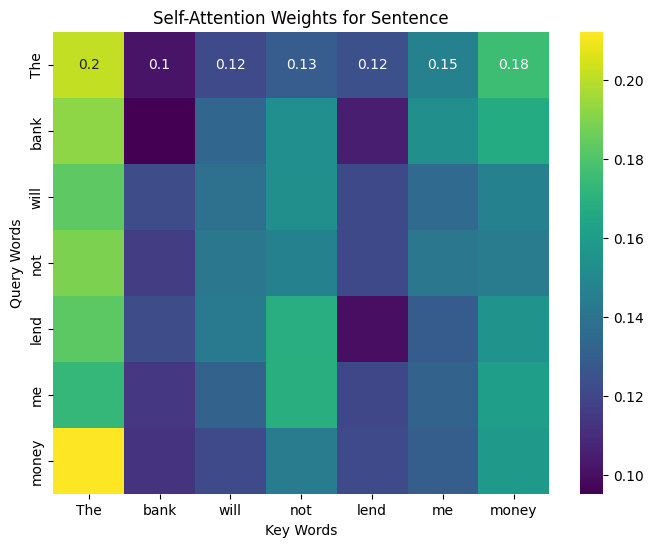


Sentence 2: The boat is near the bank


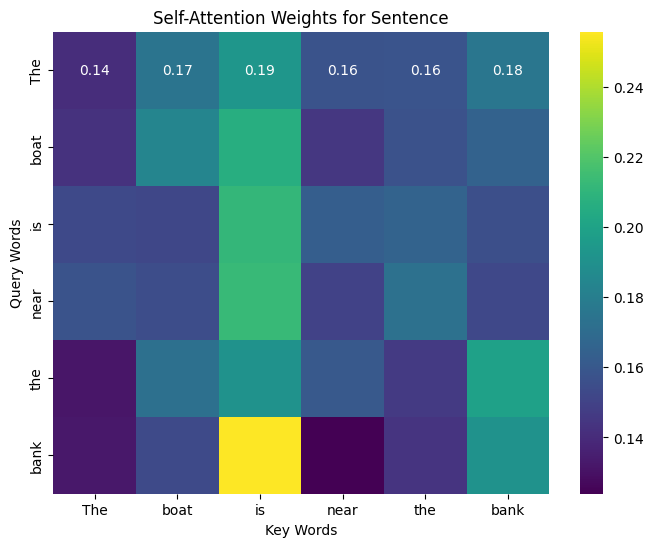


 Try with your own sentence below:


interactive(children=(Text(value='The bank will not lend me money', description='Sentence:'), Output()), _dom_…

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, Text

# Softmax function
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

# Simple self-attention (1 head) for visualization
def self_attention_visual(sentence):
    words = sentence.split()
    vocab_size = len(words)
    
    # Create one-hot embeddings
    embeddings = np.eye(vocab_size)
    np.random.seed(42)
    
    # Random weight matrices (simulating learned parameters)
    Wq = np.random.rand(vocab_size, vocab_size)
    Wk = np.random.rand(vocab_size, vocab_size)
    Wv = np.random.rand(vocab_size, vocab_size)
    
    # Compute Q, K, V
    Q = np.dot(embeddings, Wq)
    K = np.dot(embeddings, Wk)
    V = np.dot(embeddings, Wv)
    
    # Compute scaled dot-product attention
    d_k = Q.shape[-1]
    scores = np.dot(Q, K.T) / np.sqrt(d_k)
    attention_weights = softmax(scores)
    
    # Compute attention output (not used for viz)
    attention_output = np.dot(attention_weights, V)
    
    # Plot attention weights as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(attention_weights, annot=True, cmap='viridis',
                xticklabels=words, yticklabels=words)
    plt.title("Self-Attention Weights for Sentence")
    plt.xlabel("Key Words")
    plt.ylabel("Query Words")
    plt.show()
    
    return attention_weights

# --- Test with ambiguous word "bank" ---
sentence1 = "The bank will not lend me money"
sentence2 = "The boat is near the bank"

print("Sentence 1:", sentence1)
attn1 = self_attention_visual(sentence1)

print("\nSentence 2:", sentence2)
attn2 = self_attention_visual(sentence2)

# --- Interactive version ---
def interactive_attention(sentence):
    if sentence.strip() == "":
        print("Please enter a sentence.")
    else:
        self_attention_visual(sentence)

print("\n Try with your own sentence below:")
interact(interactive_attention, sentence=Text(value="The bank will not lend me money", description="Sentence:"));
